In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay
from typing import Dict, Optional
from executing import Source
from graphviz import Digraph, Source
from IPython.display import display as idisplay

# EDA

In [77]:
diabetes_full_set = pd.read_csv('./tema2_Diabet/Diabet_full.csv')
diabetes_train_set = pd.read_csv('./tema2_Diabet/Diabet_train.csv')
diabetes_test_set = pd.read_csv('./tema2_Diabet/Diabet_test.csv')

credit_risk_full_set = pd.read_csv('./tema2_Credit_Risk/credit_risk_full.csv')
credits_risk_train_set = pd.read_csv('./tema2_Credit_Risk/credit_risk_train.csv')
credits_risk_test_set = pd.read_csv('./tema2_Credit_Risk/credit_risk_test.csv')

diabetes_numerical_attributes_list = ['Body_Stats', 'Metabolical_Rate', 'psychological-rating', 'BodyMassIndex', 'Age', 'CognitionScore']
discrete_ordinal_attributes_list =  [
                                        'HealthcareInterest', 'PreCVA', 'RoutineChecks', 'CompletedEduLvl',
                                        'alcoholAbuse', 'cholesterol_ver', 'vegetables', 'HighBP',
                                        'Unprocessed_fructose', 'Jogging', 'IncreasedChol', 'gender',
                                        'HealthScore', 'myocardial_infarction', 'SalaryBraket', 'Cardio',
                                        'ImprovedAveragePulmonaryCapacity', 'Smoker'
                                    ]

credit_risk_numerical_attributes_list = [
                                        'applicant_age', 'applicant_income', 'job_tenure_years', 'loan_amount', 'loan_rate',
                                        'loan_income_ratio', 'credit_history_length_years', 'credit_history_length_months'
                                        ]
credit_risk_ordinal_attributes_list = ['residential_status', 'loan_purpose', 'loan_rating', 'credit_history_default_status', 'stability_rating']

# Diabetes Set

* Numerical Continous Fields

In [78]:
diabetes_full_set[diabetes_numerical_attributes_list].describe()

,Body_Stats,Metabolical_Rate,psychological-rating,BodyMassIndex,Age,CognitionScore
count,10000.000000,9000.000000,10000.000000,10000.000000,10000.0000,10000.000000
mean,194.960784,221.592499,4.365100,28.246500,8.0575,3.125300
std,82.438106,60.480951,8.891103,6.462563,3.0363,7.308607
min,105.063984,71.602207,0.000000,14.000000,1.0000,0.000000
25%,156.720671,180.542314,0.000000,24.000000,6.0000,0.000000
50%,174.042100,224.218817,0.000000,27.000000,8.0000,0.000000
75%,197.742249,262.688901,3.000000,31.000000,10.0000,2.000000
max,553.000000,327.936098,30.000000,92.000000,13.0000,30.000000


In [79]:
def plot_numerical_attributes(dataset, attributes):
    num_attributes = len(attributes)
    fig, axes = plt.subplots(1, num_attributes, figsize=(6*num_attributes, 15))
    
    for i, attribute in enumerate(attributes):
        dataset.boxplot(column=attribute, patch_artist=True, ax=axes[i])
        axes[i].set_title(attribute)
    
    plt.tight_layout()
    plt.show()

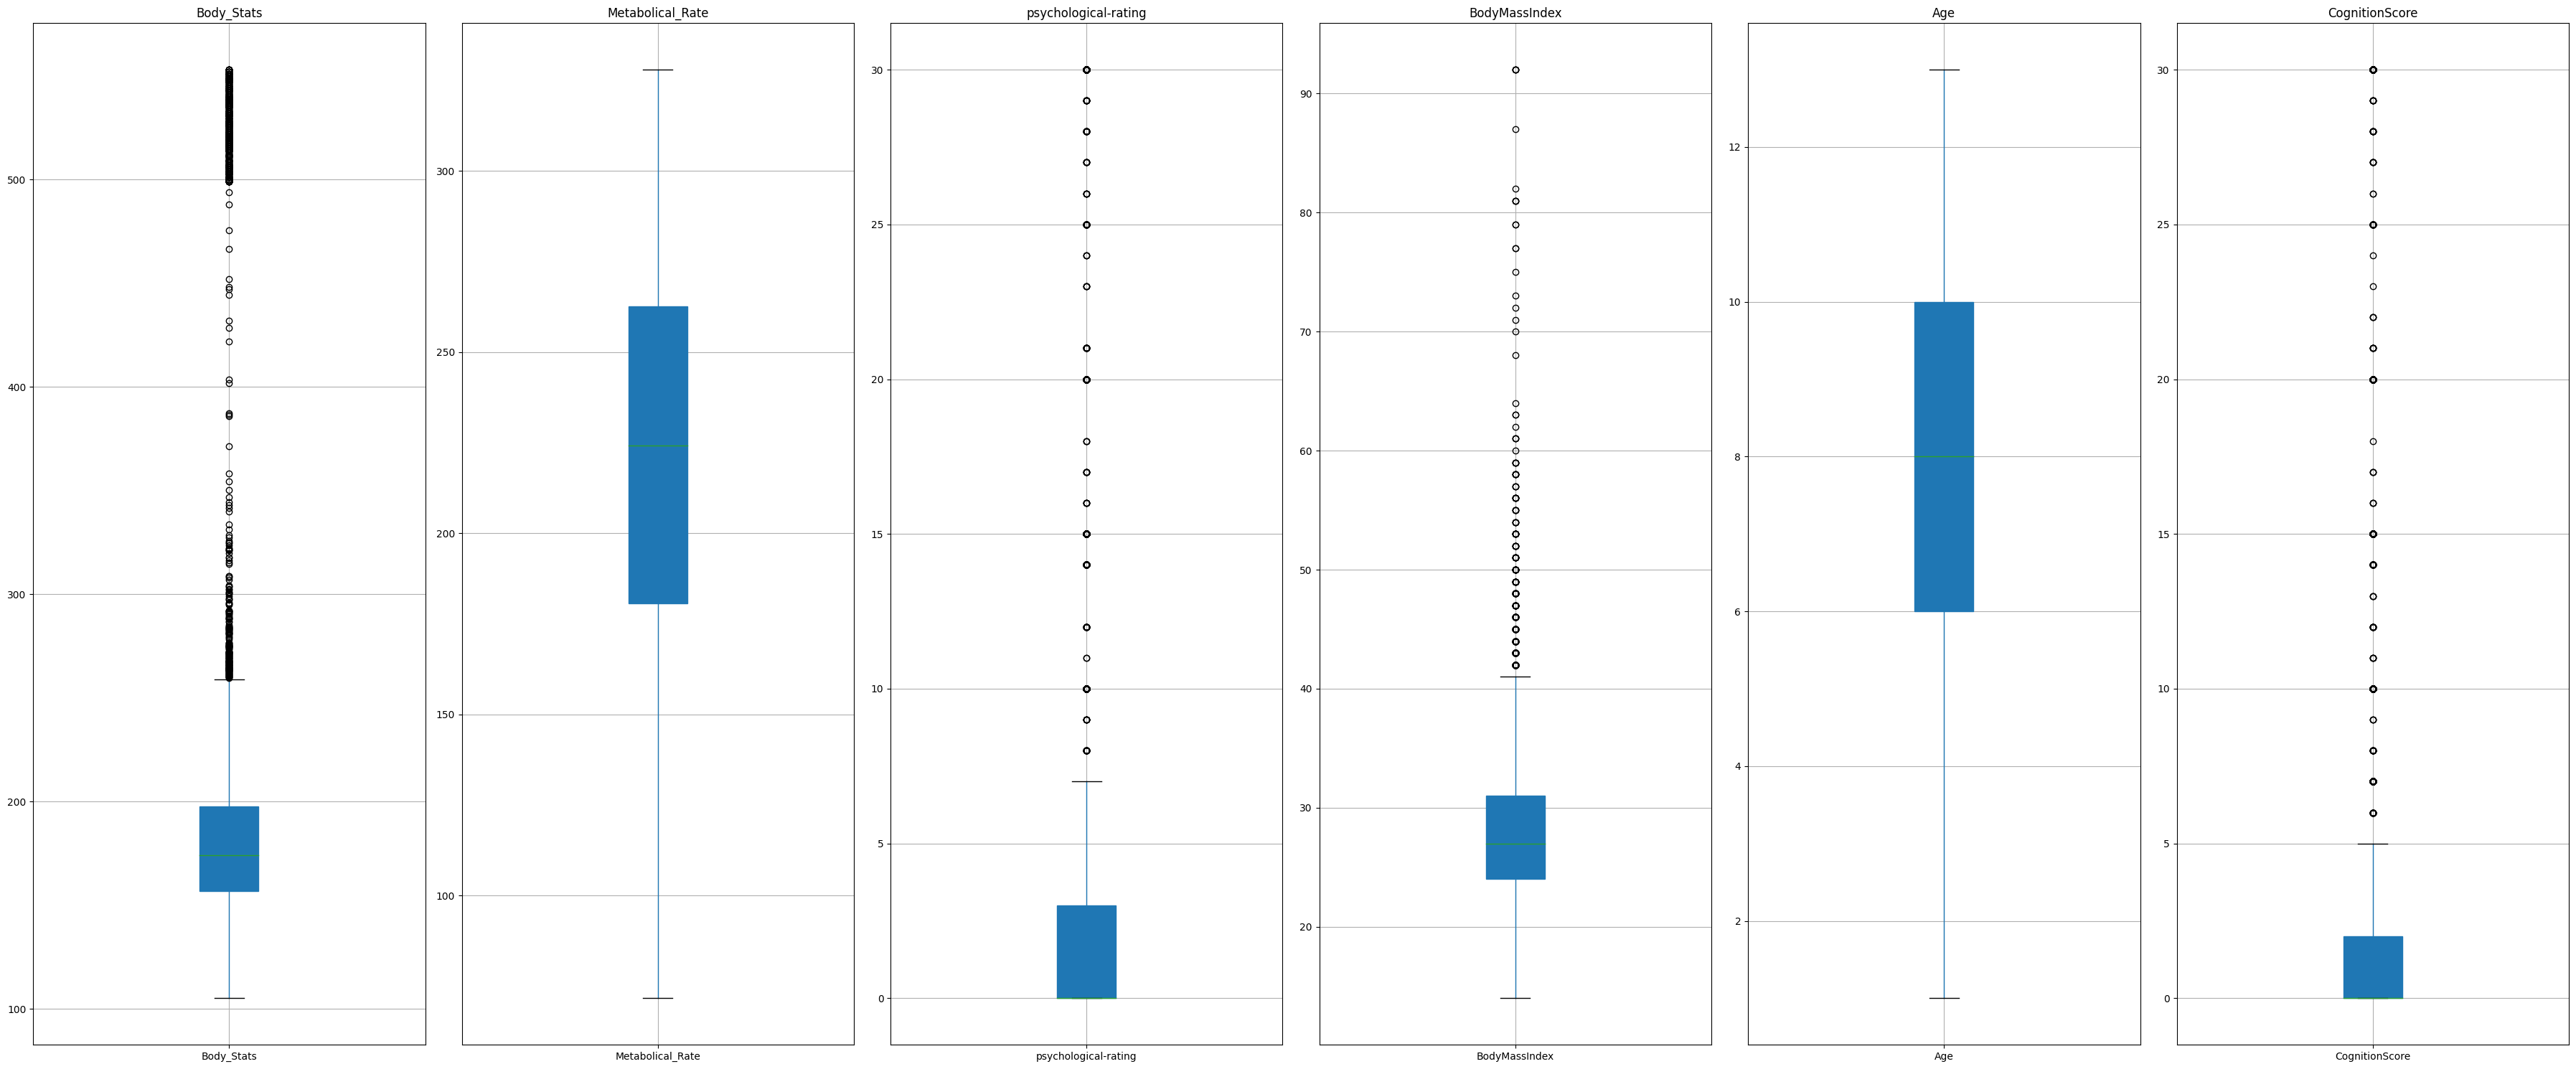

In [80]:
plot_numerical_attributes(diabetes_full_set, ['Body_Stats', 'Metabolical_Rate', 'psychological-rating', 'BodyMassIndex', 'Age', 'CognitionScore'])

* Discrete/Ordinal Fields

In [81]:
def get_discrete_ordinal_attributes(dataset, attributes):
    tables = []

    for attribute in attributes:
        attribute_characteristics = (dataset[attribute].count(), dataset[attribute].dropna().unique().shape[0])

        tables.append(pd.DataFrame({'count': attribute_characteristics[0], 'unique': attribute_characteristics[1]}, index = [attribute]))

    return pd.concat(tables)

In [82]:
discrete_ordinal_attributes = get_discrete_ordinal_attributes(diabetes_full_set, discrete_ordinal_attributes_list)
discrete_ordinal_attributes

,count,unique
HealthcareInterest,10000,2
PreCVA,10000,2
RoutineChecks,10000,2
CompletedEduLvl,9000,6
alcoholAbuse,10000,2
cholesterol_ver,10000,2
vegetables,10000,2
HighBP,10000,2
Unprocessed_fructose,10000,2
Jogging,10000,2


In [83]:
def plot_discrete_ordinal_attributes(dataset, attributes, widths):
    for (attribute, width) in zip(attributes, widths):
        dataset[attribute].hist(bins=dataset[attribute].value_counts().shape[0], width=width)
        plt.xlabel(attribute)
        plt.ylabel('Frequency')
        plt.title(attribute)
        plt.show()

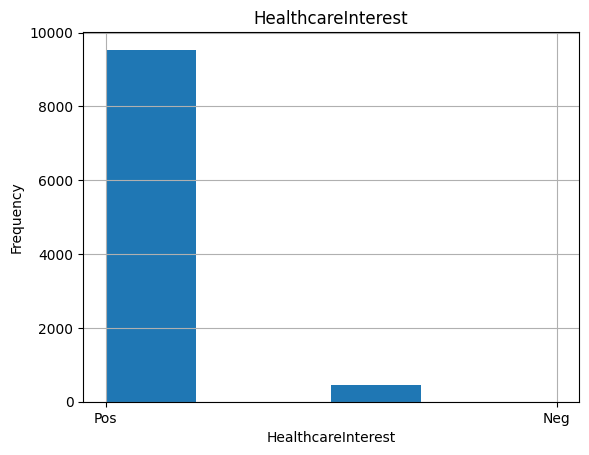

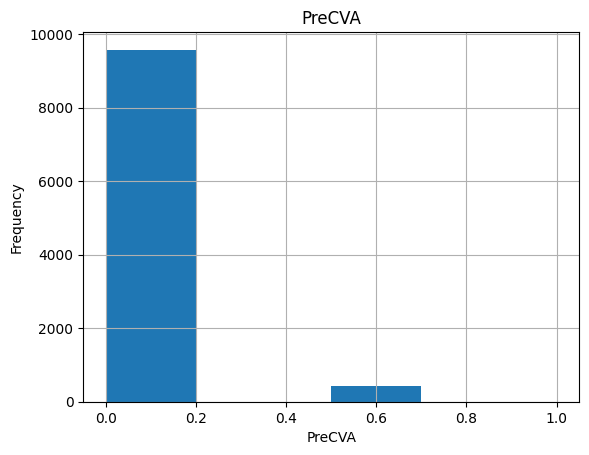

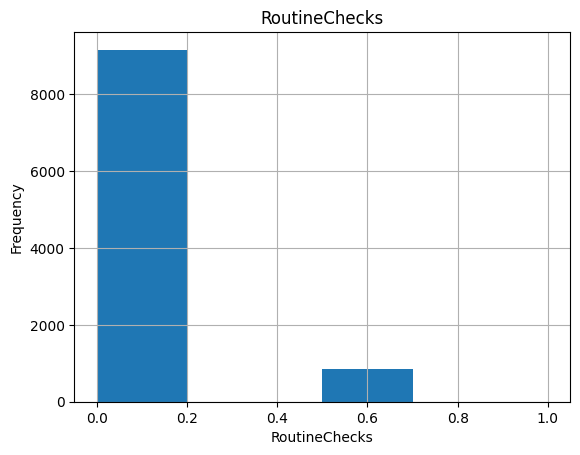

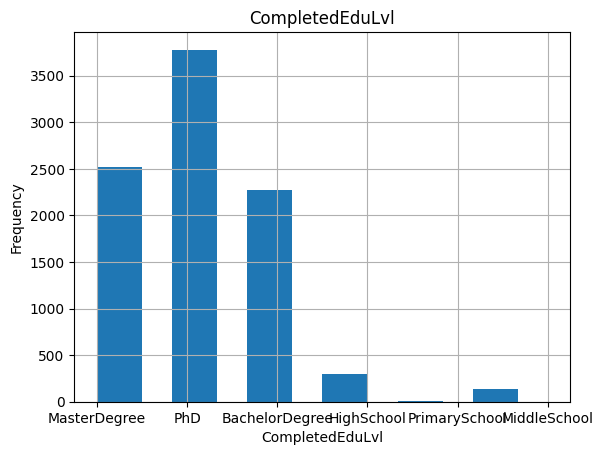

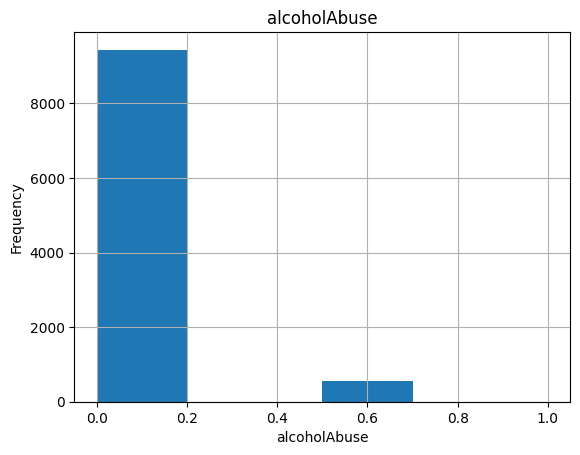

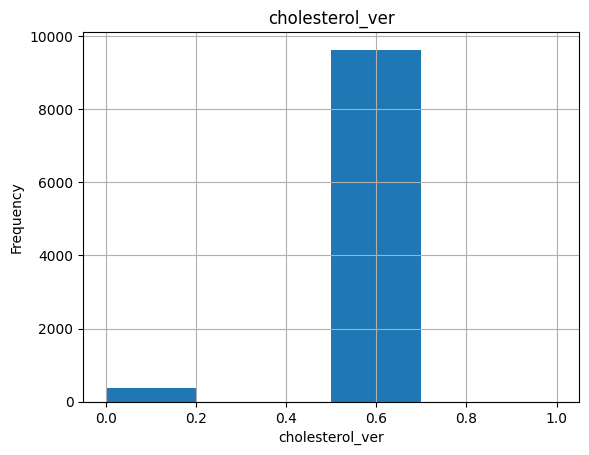

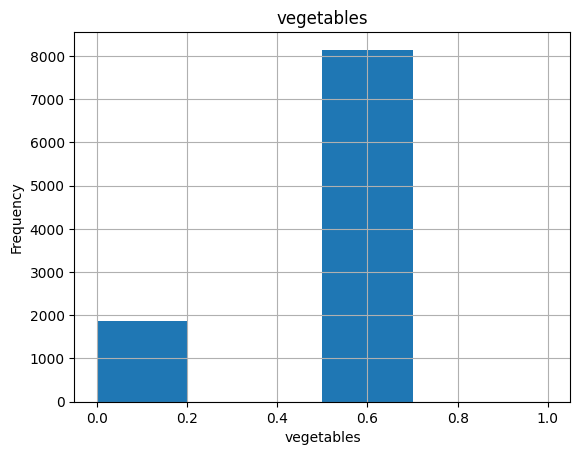

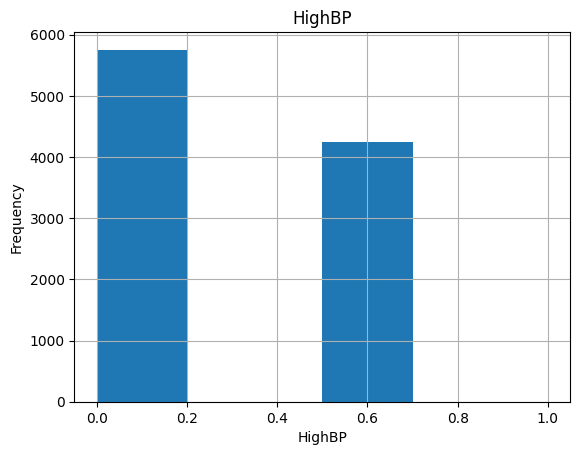

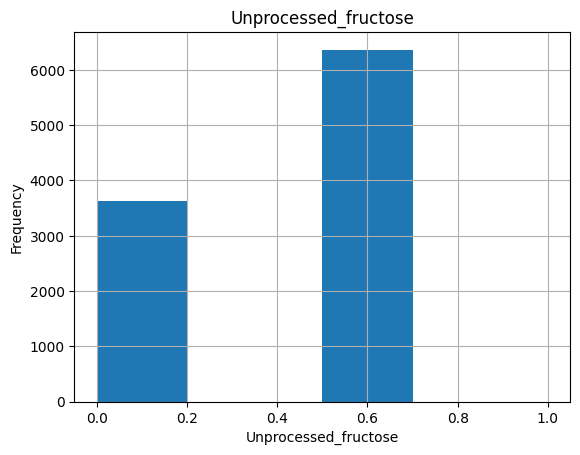

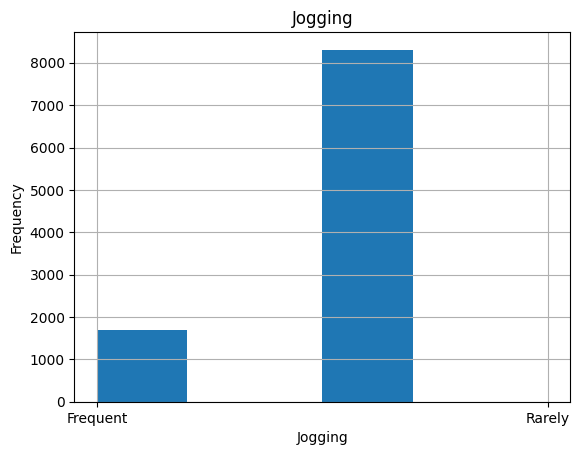

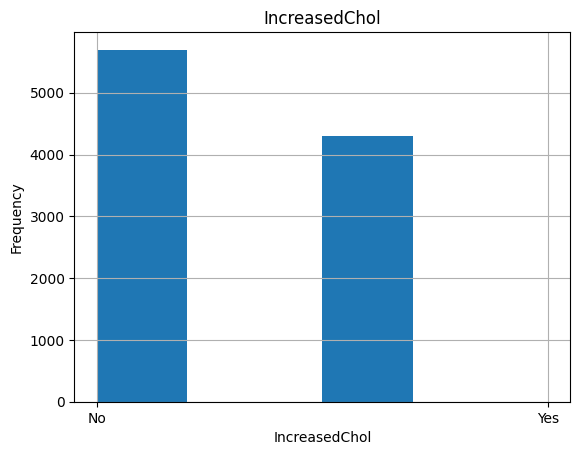

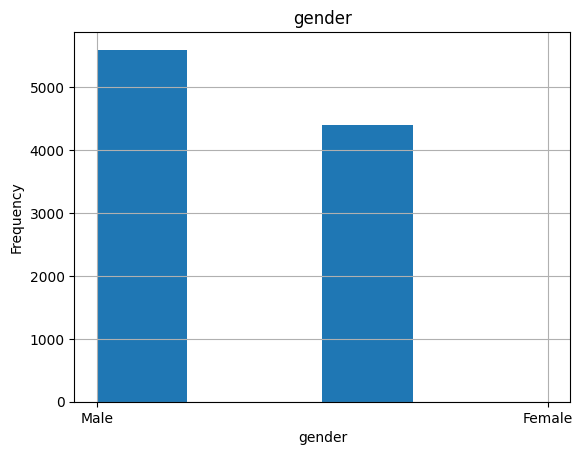

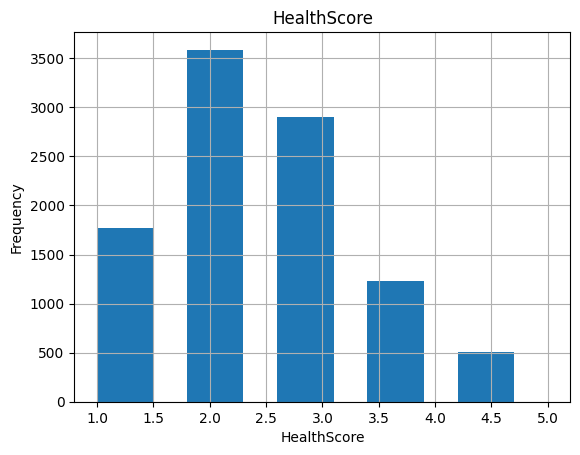

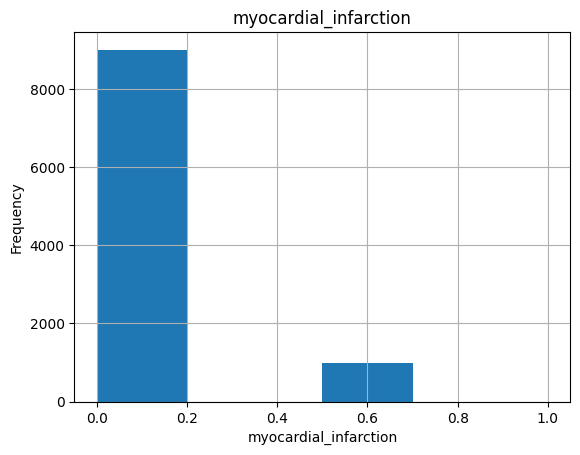

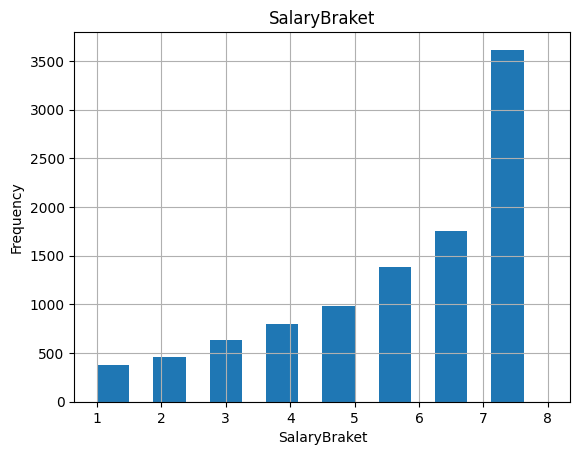

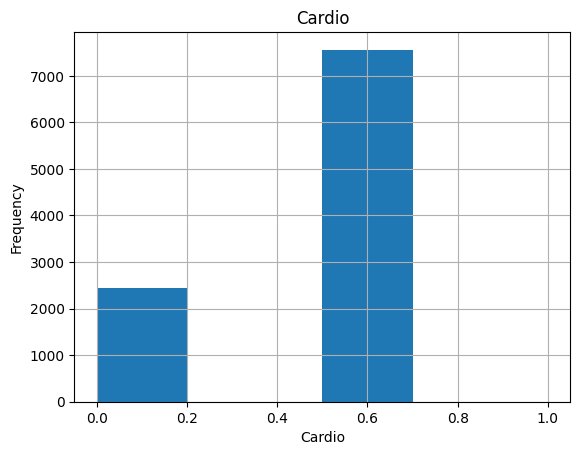

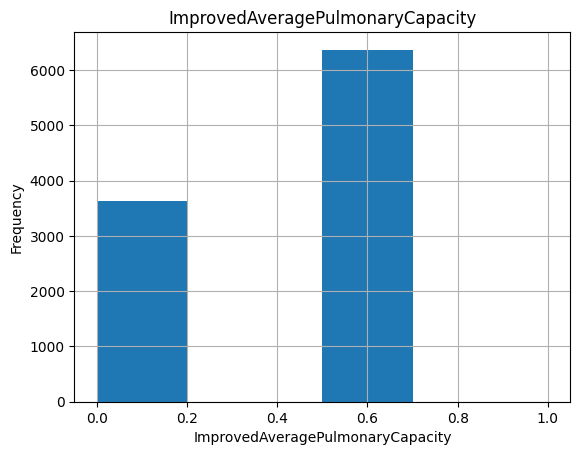

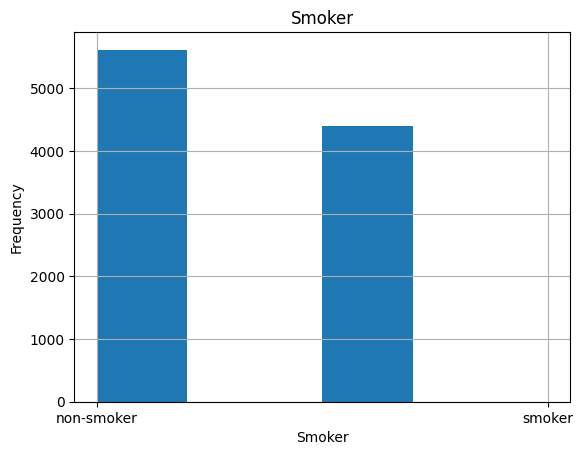

In [84]:
plot_discrete_ordinal_attributes(diabetes_full_set, 
                                discrete_ordinal_attributes_list,
                                [
                                    0.2, 0.2, 0.2, 0.5, 0.2, 0.2, 0.2, 0.2, 0.2,
                                    0.2, 0.2, 0.2, 0.5, 0.2, 0.5, 0.2, 0.2, 0.2
                                ])

In [85]:
def plot_labels(datasets, names, label):
    for (dataset, name) in zip(datasets, names):
        new_dataset = dataset[label].dropna().to_frame()
        sns.countplot(x = label, data = new_dataset)
        plt.title(name)
        plt.show()

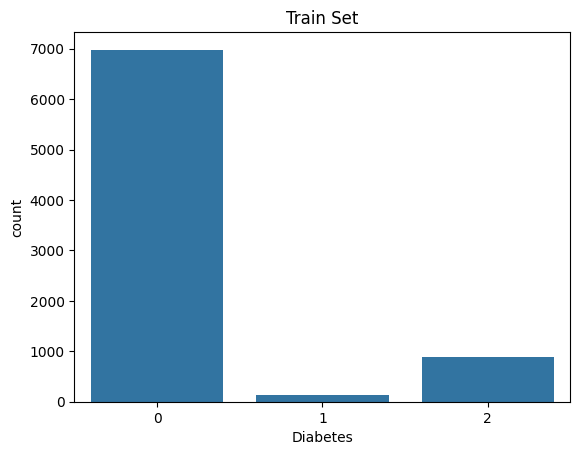

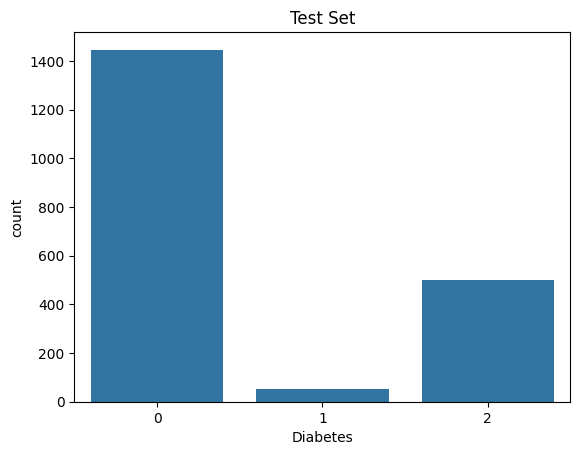

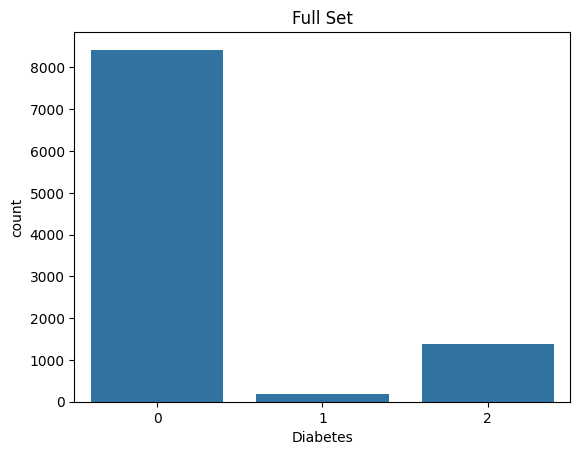

In [86]:
plot_labels([diabetes_train_set, diabetes_test_set, diabetes_full_set], ['Train Set', 'Test Set', 'Full Set'], 'Diabetes')

In [87]:
def get_corr_matrix_numerical_attributes(dataset, attributes):
    return dataset[attributes].corr(method = 'pearson')

In [88]:
corr_matrix = get_corr_matrix_numerical_attributes(diabetes_full_set, diabetes_numerical_attributes_list)
corr_matrix

,Body_Stats,Metabolical_Rate,psychological-rating,BodyMassIndex,Age,CognitionScore
Body_Stats,1.000000,0.001973,0.054565,0.367735,0.004131,0.031467
Metabolical_Rate,0.001973,1.000000,0.098969,-0.031751,0.998715,-0.092739
psychological-rating,0.054565,0.098969,1.000000,0.137346,0.102714,0.348891
BodyMassIndex,0.367735,-0.031751,0.137346,1.000000,-0.027297,0.088760
Age,0.004131,0.998715,0.102714,-0.027297,1.000000,-0.091496
CognitionScore,0.031467,-0.092739,0.348891,0.088760,-0.091496,1.000000


In [89]:
def plot_heat_map(matrix):
    fig = plt.figure(figsize=(13, 13))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix, cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0, len(matrix.columns), 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    plt.show()

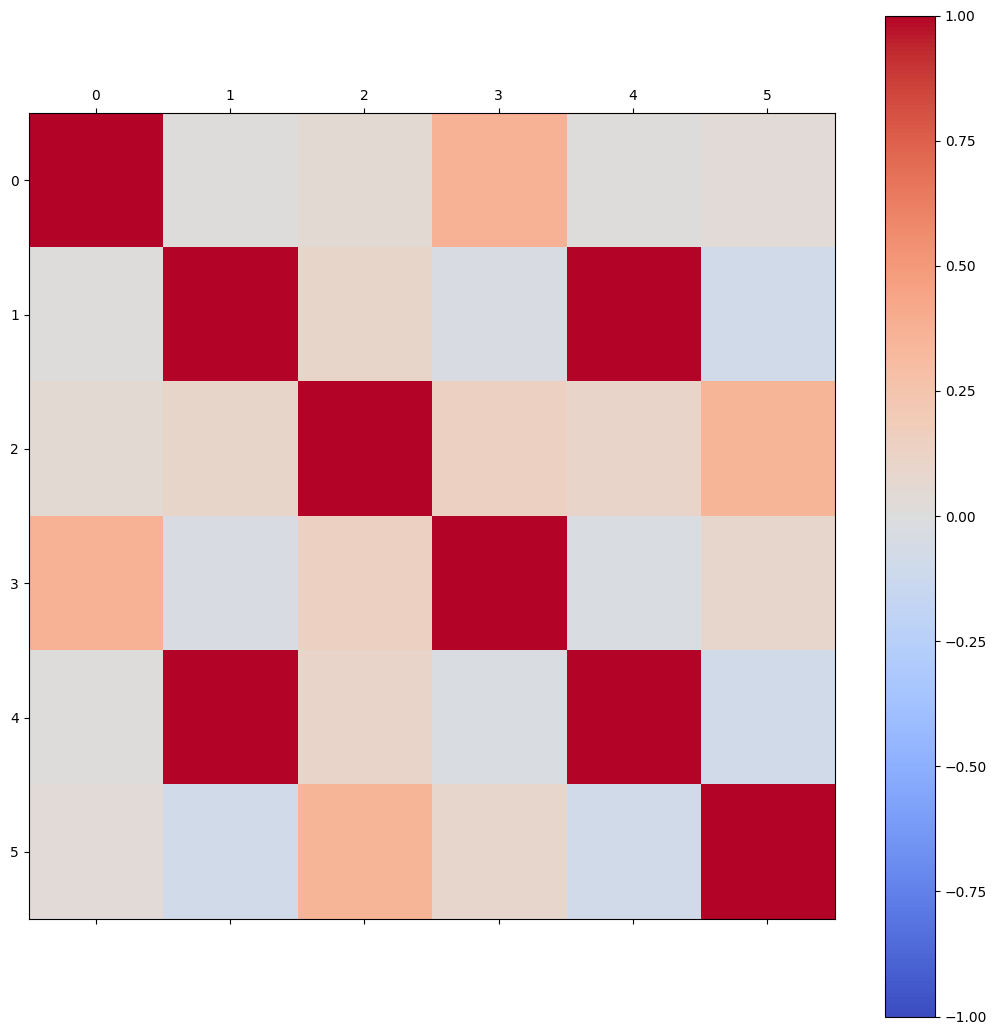

In [90]:
plot_heat_map(corr_matrix)

In [91]:
def get_corr_matrix_discrete_ordinal_attributes(dataset, attributes):
    matrix = pd.DataFrame(index=attributes, columns=attributes)

    for i in range(len(attributes)):
        for j in range(i, len(attributes)):
            if i == j:
                matrix.at[attributes[i], attributes[j]] = 1
                continue

            attribute1 = attributes[i]
            attribute2 = attributes[j]
            
            table = pd.crosstab(dataset[attribute1], dataset[attribute2], margins=False)
            _, p, _, _ = chi2_contingency(table)
            matrix.at[attribute1, attribute2] = 1 - p
            matrix.at[attribute2, attribute1] = 1 - p

    return matrix.astype(float)

In [92]:
corr_matrix_discrete_ordinal_attributes = get_corr_matrix_discrete_ordinal_attributes(diabetes_full_set, discrete_ordinal_attributes_list)

corr_matrix_discrete_ordinal_attributes

,HealthcareInterest,PreCVA,RoutineChecks,CompletedEduLvl,alcoholAbuse,cholesterol_ver,vegetables,HighBP,Unprocessed_fructose,Jogging,IncreasedChol,gender,HealthScore,myocardial_infarction,SalaryBraket,Cardio,ImprovedAveragePulmonaryCapacity,Smoker
HealthcareInterest,1.000000,0.532517,1.000000,1.000000,0.999977,1.000000,0.932094,0.999301,0.999762,0.578119,0.999999,0.391988,0.999942,0.981227,1.000000,0.998532,0.999762,0.998856
PreCVA,0.532517,1.000000,0.998870,1.000000,0.607375,0.930582,0.999579,1.000000,0.990318,1.000000,1.000000,0.555641,1.000000,1.000000,1.000000,1.000000,0.990318,1.000000
RoutineChecks,1.000000,0.998870,1.000000,1.000000,0.060479,0.999355,0.959673,0.727820,0.999989,1.000000,0.728004,0.999998,1.000000,0.999182,1.000000,1.000000,0.999989,1.000000
CompletedEduLvl,1.000000,1.000000,1.000000,1.000000,0.976403,0.716077,1.000000,1.000000,1.000000,1.000000,1.000000,0.870074,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
alcoholAbuse,0.999977,0.607375,0.060479,0.976403,1.000000,0.990301,0.355668,0.603970,0.998398,0.989114,0.604818,0.808069,0.961438,0.999914,0.998497,0.762771,0.998398,1.000000
cholesterol_ver,1.000000,0.930582,0.999355,0.716077,0.990301,1.000000,0.768185,1.000000,0.972899,0.999996,1.000000,0.994469,1.000000,0.999996,0.156600,0.330694,0.972899,0.815096
vegetables,0.932094,0.999579,0.959673,1.000000,0.355668,0.768185,1.000000,0.999994,1.000000,1.000000,0.999420,1.000000,1.000000,0.999176,1.000000,1.000000,1.000000,0.999954
HighBP,0.999301,1.000000,0.727820,1.000000,0.603970,1.000000,0.999994,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Unprocessed_fructose,0.999762,0.990318,0.999989,1.000000,0.998398,0.972899,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.651120,1.000000,1.000000,1.000000,1.000000
Jogging,0.578119,1.000000,1.000000,1.000000,0.989114,0.999996,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


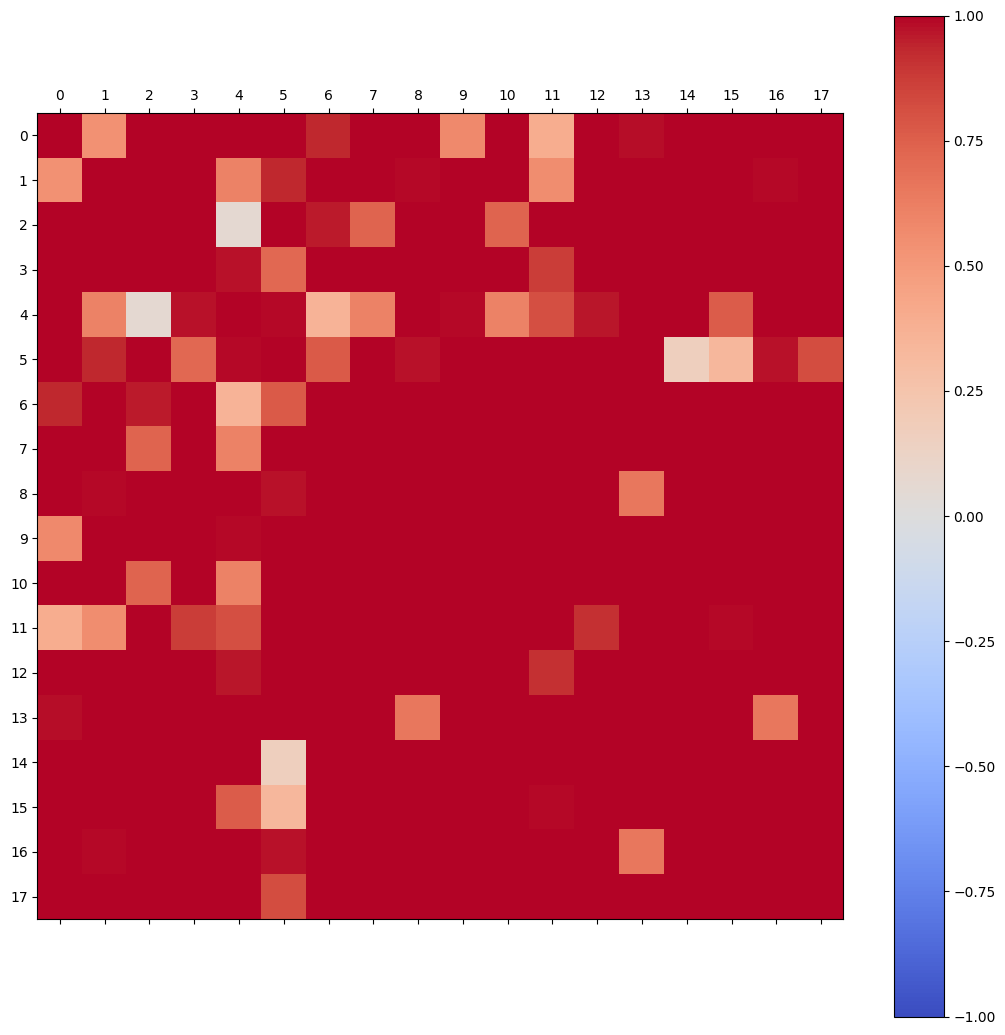

In [93]:
plot_heat_map(corr_matrix_discrete_ordinal_attributes)

# Data Preprocessing

In [94]:
def get_missing_numerical_values(dataset, attributes):
    imputer = IterativeImputer(random_state=0, n_nearest_features=5)
    imputer.fit(dataset[attributes])
    dataset[attributes] = imputer.transform(dataset[attributes])
    return dataset[attributes]

In [95]:
diabetes_full_set[diabetes_numerical_attributes_list] = get_missing_numerical_values(diabetes_full_set, diabetes_numerical_attributes_list)
diabetes_train_set[diabetes_numerical_attributes_list] = get_missing_numerical_values(diabetes_train_set, diabetes_numerical_attributes_list)
diabetes_test_set[diabetes_numerical_attributes_list] = get_missing_numerical_values(diabetes_test_set, diabetes_numerical_attributes_list)

In [96]:
def get_missing_discrete_ordinal_values(dataset, attributes):
    imputer = SimpleImputer(strategy='most_frequent')
    imputer.fit(dataset[attributes])
    dataset[attributes] = imputer.transform(dataset[attributes])
    return dataset[attributes]

In [97]:
diabetes_full_set[discrete_ordinal_attributes_list] = get_missing_discrete_ordinal_values(diabetes_full_set, discrete_ordinal_attributes_list)
diabetes_train_set[discrete_ordinal_attributes_list] = get_missing_discrete_ordinal_values(diabetes_train_set, discrete_ordinal_attributes_list)
diabetes_test_set[discrete_ordinal_attributes_list] = get_missing_discrete_ordinal_values(diabetes_test_set, discrete_ordinal_attributes_list)

In [98]:
def get_outliers(dataset, attributes, Q1_percentage, Q3_percentage, tolerance):
    for attribute in attributes:
        Q1 = dataset[attribute].quantile(Q1_percentage)
        Q3 = dataset[attribute].quantile(Q3_percentage)
        IQR = Q3 - Q1
        lower_bound = Q1 - tolerance * IQR
        upper_bound = Q3 + tolerance * IQR
        outliers = dataset[(dataset[attribute] < lower_bound) | (dataset[attribute] > upper_bound)]
        dataset = dataset.drop(outliers.index)
    return dataset[attributes]

In [99]:
# Full Set
diabetes_full_set[diabetes_numerical_attributes_list] = get_outliers(diabetes_full_set, diabetes_numerical_attributes_list, 0.25, 0.75, 1.5)
diabetes_full_set[diabetes_numerical_attributes_list] = get_missing_numerical_values(diabetes_full_set, diabetes_numerical_attributes_list)
diabetes_full_set[diabetes_numerical_attributes_list].describe()

,Body_Stats,Metabolical_Rate,psychological-rating,BodyMassIndex,Age,CognitionScore
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,172.701411,223.135683,0.619233,27.289900,8.156484,0.165368
std,19.697245,48.423698,1.182970,3.805697,2.419933,0.406412
min,106.352196,71.602207,0.000000,14.000000,1.000000,0.000000
25%,163.850211,215.761108,0.000000,26.000000,8.000000,0.000000
50%,172.701411,223.135683,0.000000,27.289900,8.156484,0.000000
75%,177.314662,243.165035,0.619233,28.000000,9.000000,0.165368
max,254.237279,327.936098,7.000000,41.000000,13.000000,2.000000


In [100]:
# Train Set
diabetes_train_set[diabetes_numerical_attributes_list] = get_outliers(diabetes_train_set, diabetes_numerical_attributes_list, 0.25, 0.75, 1.5)
diabetes_train_set[diabetes_numerical_attributes_list] = get_missing_numerical_values(diabetes_train_set, diabetes_numerical_attributes_list)
diabetes_train_set[diabetes_numerical_attributes_list].describe()

,Body_Stats,Metabolical_Rate,psychological-rating,BodyMassIndex,Age,CognitionScore
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,171.568363,222.313114,0.615310,27.070900,8.115699,0.164394
std,18.854878,48.732702,1.181029,3.636128,2.436576,0.404879
min,106.352196,73.557000,0.000000,15.000000,1.000000,0.000000
25%,163.314107,214.656662,0.000000,25.000000,8.000000,0.000000
50%,171.568363,222.313114,0.000000,27.070900,8.115699,0.000000
75%,176.277444,242.615166,0.615310,28.000000,9.000000,0.164394
max,242.176299,327.936098,7.000000,39.000000,13.000000,2.000000


In [101]:
# Test Set
diabetes_test_set[diabetes_numerical_attributes_list] = get_outliers(diabetes_test_set, diabetes_numerical_attributes_list, 0.25, 0.75, 1.5)
diabetes_test_set[diabetes_numerical_attributes_list] = get_missing_numerical_values(diabetes_test_set, diabetes_numerical_attributes_list)
diabetes_test_set[diabetes_numerical_attributes_list].describe()

,Body_Stats,Metabolical_Rate,psychological-rating,BodyMassIndex,Age,CognitionScore
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,174.868334,227.502839,0.846460,27.696102,8.372315,0.175815
std,20.179159,46.739235,1.590896,3.901098,2.331222,0.416124
min,111.704232,71.602207,0.000000,16.000000,1.000000,0.000000
25%,166.368825,219.513440,0.000000,26.000000,8.000000,0.000000
50%,174.868334,227.502839,0.846460,27.696102,8.372315,0.000000
75%,179.587696,246.544529,0.846460,29.000000,9.000000,0.175815
max,252.118321,326.525697,10.000000,41.000000,13.000000,2.000000


In [102]:
corr_matrix = get_corr_matrix_numerical_attributes(diabetes_full_set, diabetes_numerical_attributes_list)
corr_matrix

,Body_Stats,Metabolical_Rate,psychological-rating,BodyMassIndex,Age,CognitionScore
Body_Stats,1.000000,-0.006922,0.027491,0.964907,-0.007173,-0.015202
Metabolical_Rate,-0.006922,1.000000,-0.006447,-0.010392,0.998829,-0.113247
psychological-rating,0.027491,-0.006447,1.000000,0.032194,-0.005684,0.096311
BodyMassIndex,0.964907,-0.010392,0.032194,1.000000,-0.010784,-0.022216
Age,-0.007173,0.998829,-0.005684,-0.010784,1.000000,-0.113183
CognitionScore,-0.015202,-0.113247,0.096311,-0.022216,-0.113183,1.000000


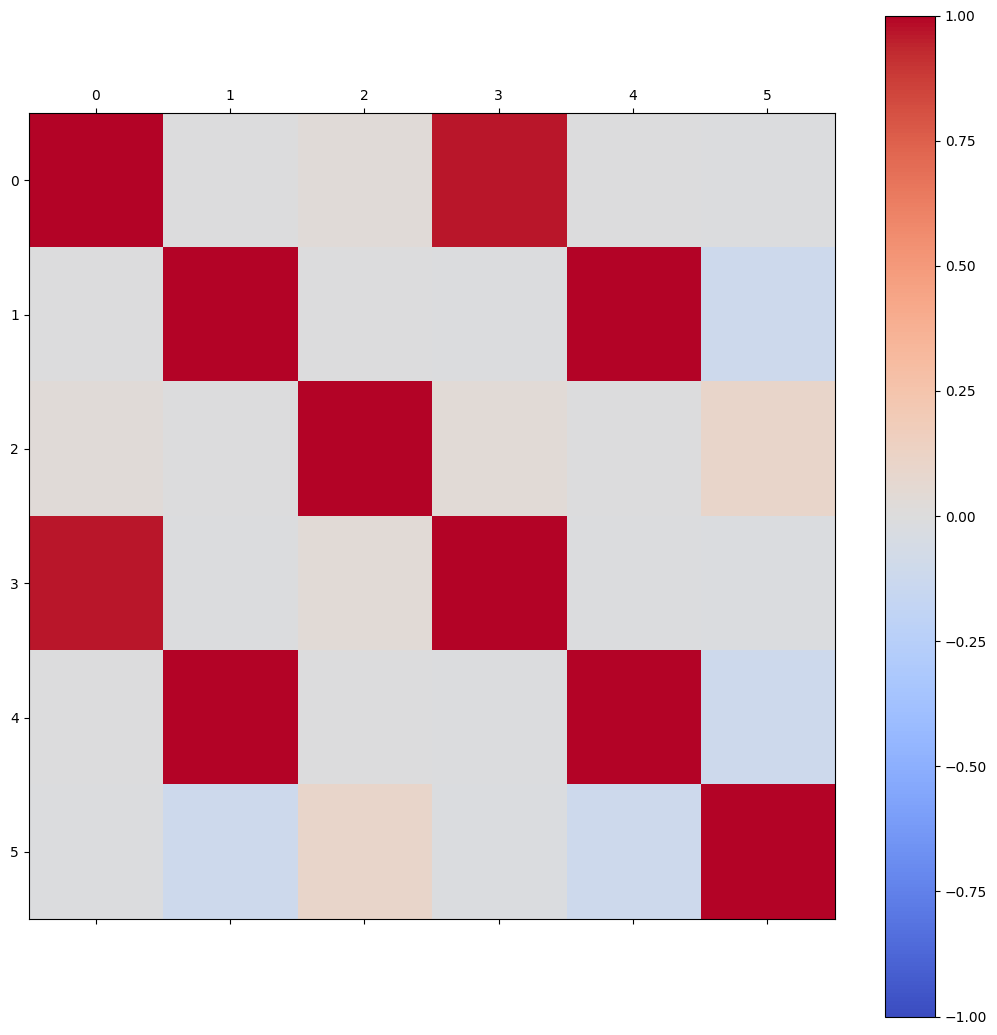

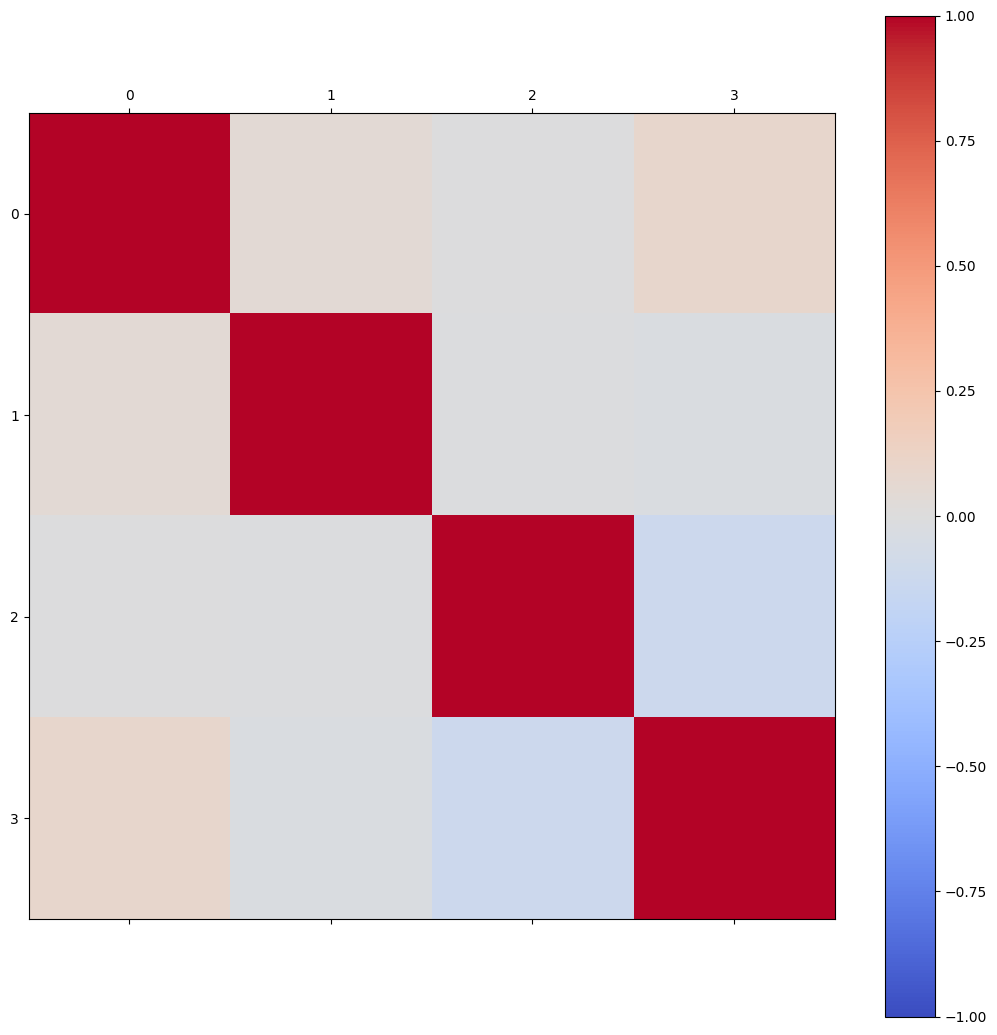

In [103]:
from copy import deepcopy

plot_heat_map(corr_matrix)
diabetes_full_set = diabetes_full_set.drop(columns=['Body_Stats', 'Metabolical_Rate'])
diabetes_numerical_atributes_elimination = deepcopy(diabetes_numerical_attributes_list)
diabetes_numerical_atributes_elimination.remove('Body_Stats')
diabetes_numerical_atributes_elimination.remove('Metabolical_Rate')
corr_matrix = get_corr_matrix_numerical_attributes(diabetes_train_set, diabetes_numerical_atributes_elimination)
plot_heat_map(corr_matrix)

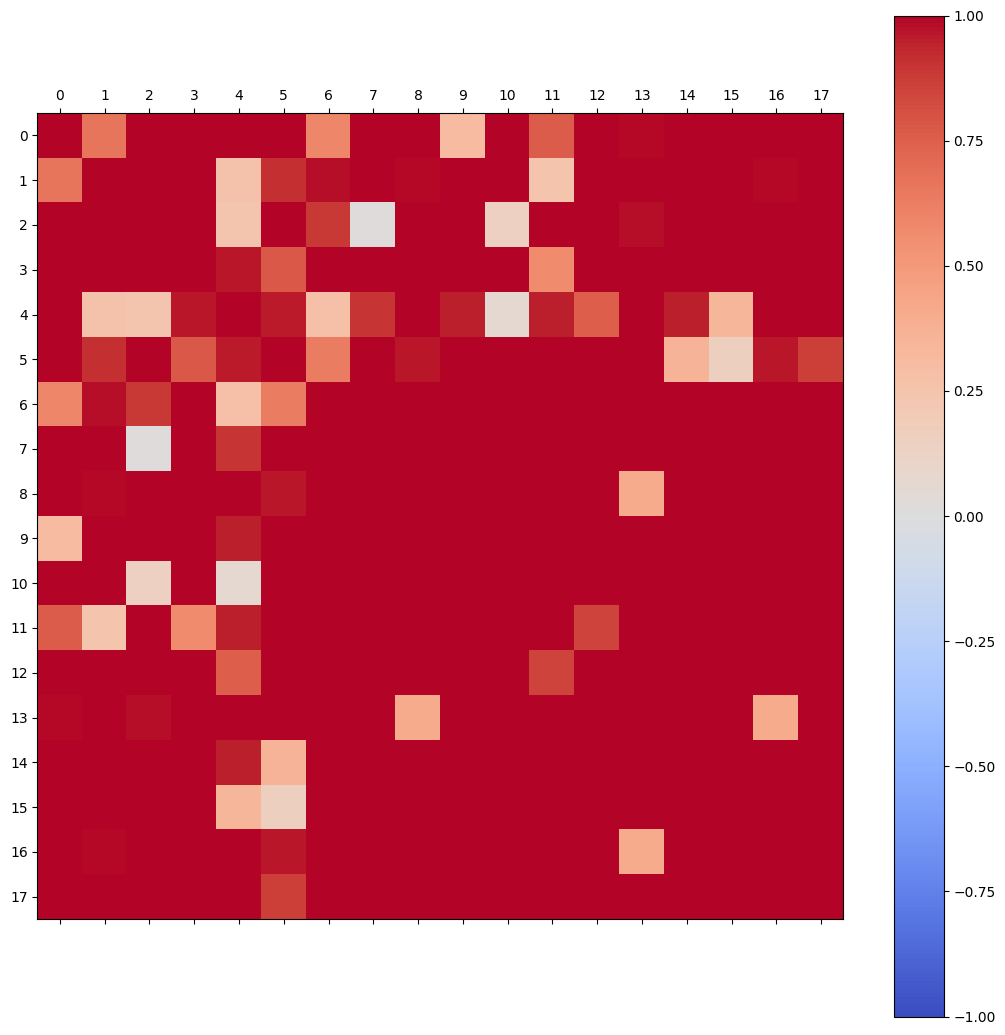

['RoutineChecks', 'alcoholAbuse', 'IncreasedChol']


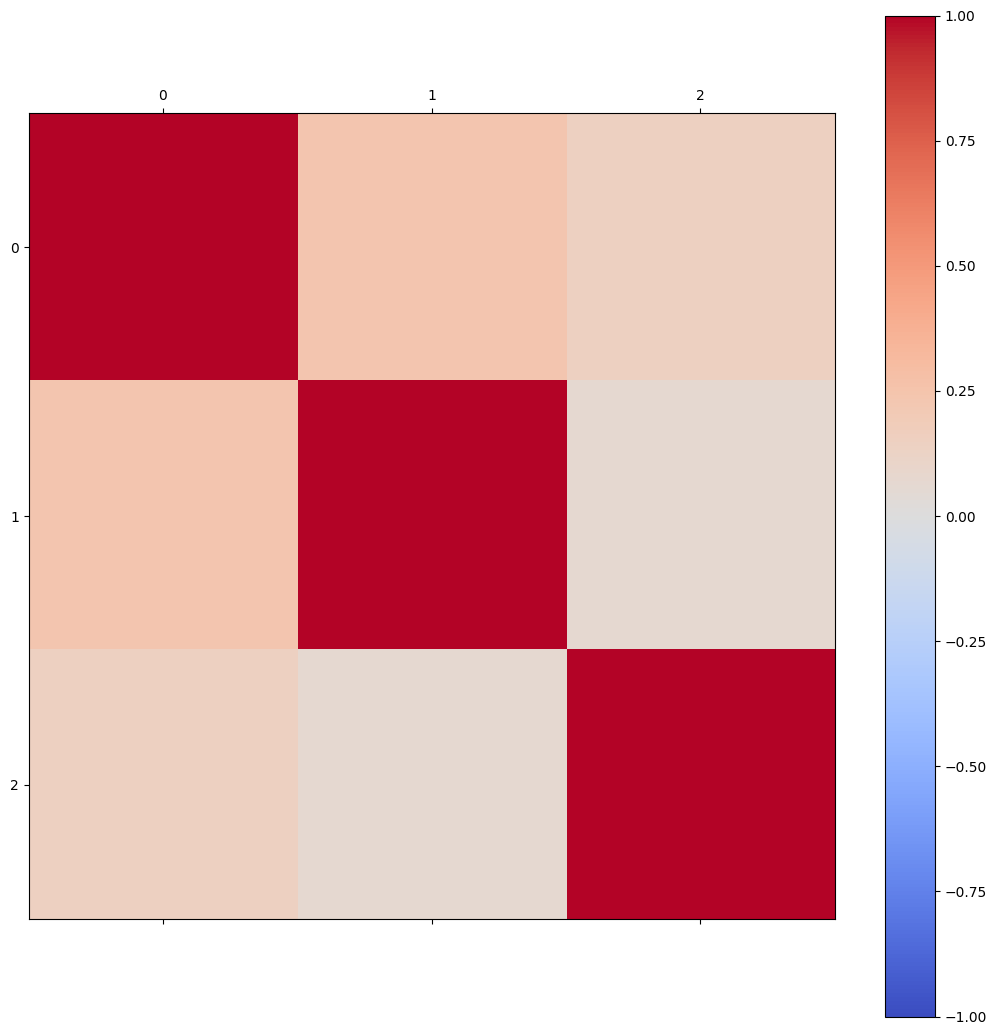

{'RoutineChecks': 0.4610474983482639, 'alcoholAbuse': 0.4337901837219385, 'IncreasedChol': 0.40472944315267495}


In [104]:
corr_matrix = get_corr_matrix_discrete_ordinal_attributes(diabetes_train_set, discrete_ordinal_attributes_list)
plot_heat_map(corr_matrix)

discrete_ordinal_attributes_list_elimination = deepcopy(discrete_ordinal_attributes_list)
discrete_ordinal_attributes_list_elimination.remove('Smoker')
discrete_ordinal_attributes_list_elimination.remove('ImprovedAveragePulmonaryCapacity')
discrete_ordinal_attributes_list_elimination.remove('CompletedEduLvl')
discrete_ordinal_attributes_list_elimination.remove('HealthScore')
discrete_ordinal_attributes_list_elimination.remove('Jogging')
discrete_ordinal_attributes_list_elimination.remove('Unprocessed_fructose')
discrete_ordinal_attributes_list_elimination.remove('myocardial_infarction')
discrete_ordinal_attributes_list_elimination.remove('SalaryBraket')
discrete_ordinal_attributes_list_elimination.remove('HealthcareInterest')
discrete_ordinal_attributes_list_elimination.remove('gender')
discrete_ordinal_attributes_list_elimination.remove('PreCVA')
discrete_ordinal_attributes_list_elimination.remove('HighBP')
discrete_ordinal_attributes_list_elimination.remove('vegetables')
discrete_ordinal_attributes_list_elimination.remove('cholesterol_ver')
discrete_ordinal_attributes_list_elimination.remove('Cardio')

print(discrete_ordinal_attributes_list_elimination)

corr_matrix = get_corr_matrix_discrete_ordinal_attributes(diabetes_train_set, discrete_ordinal_attributes_list_elimination)
plot_heat_map(corr_matrix)

means = {}
for attribute in discrete_ordinal_attributes_list_elimination:
    means[attribute] = corr_matrix[attribute].mean()
print(means)

In [105]:
def normalize_numerical_attributes(dataset, attributes):
    scaler = preprocessing.StandardScaler()
    dataset[attributes] = scaler.fit_transform(dataset[attributes])
    return dataset[attributes]

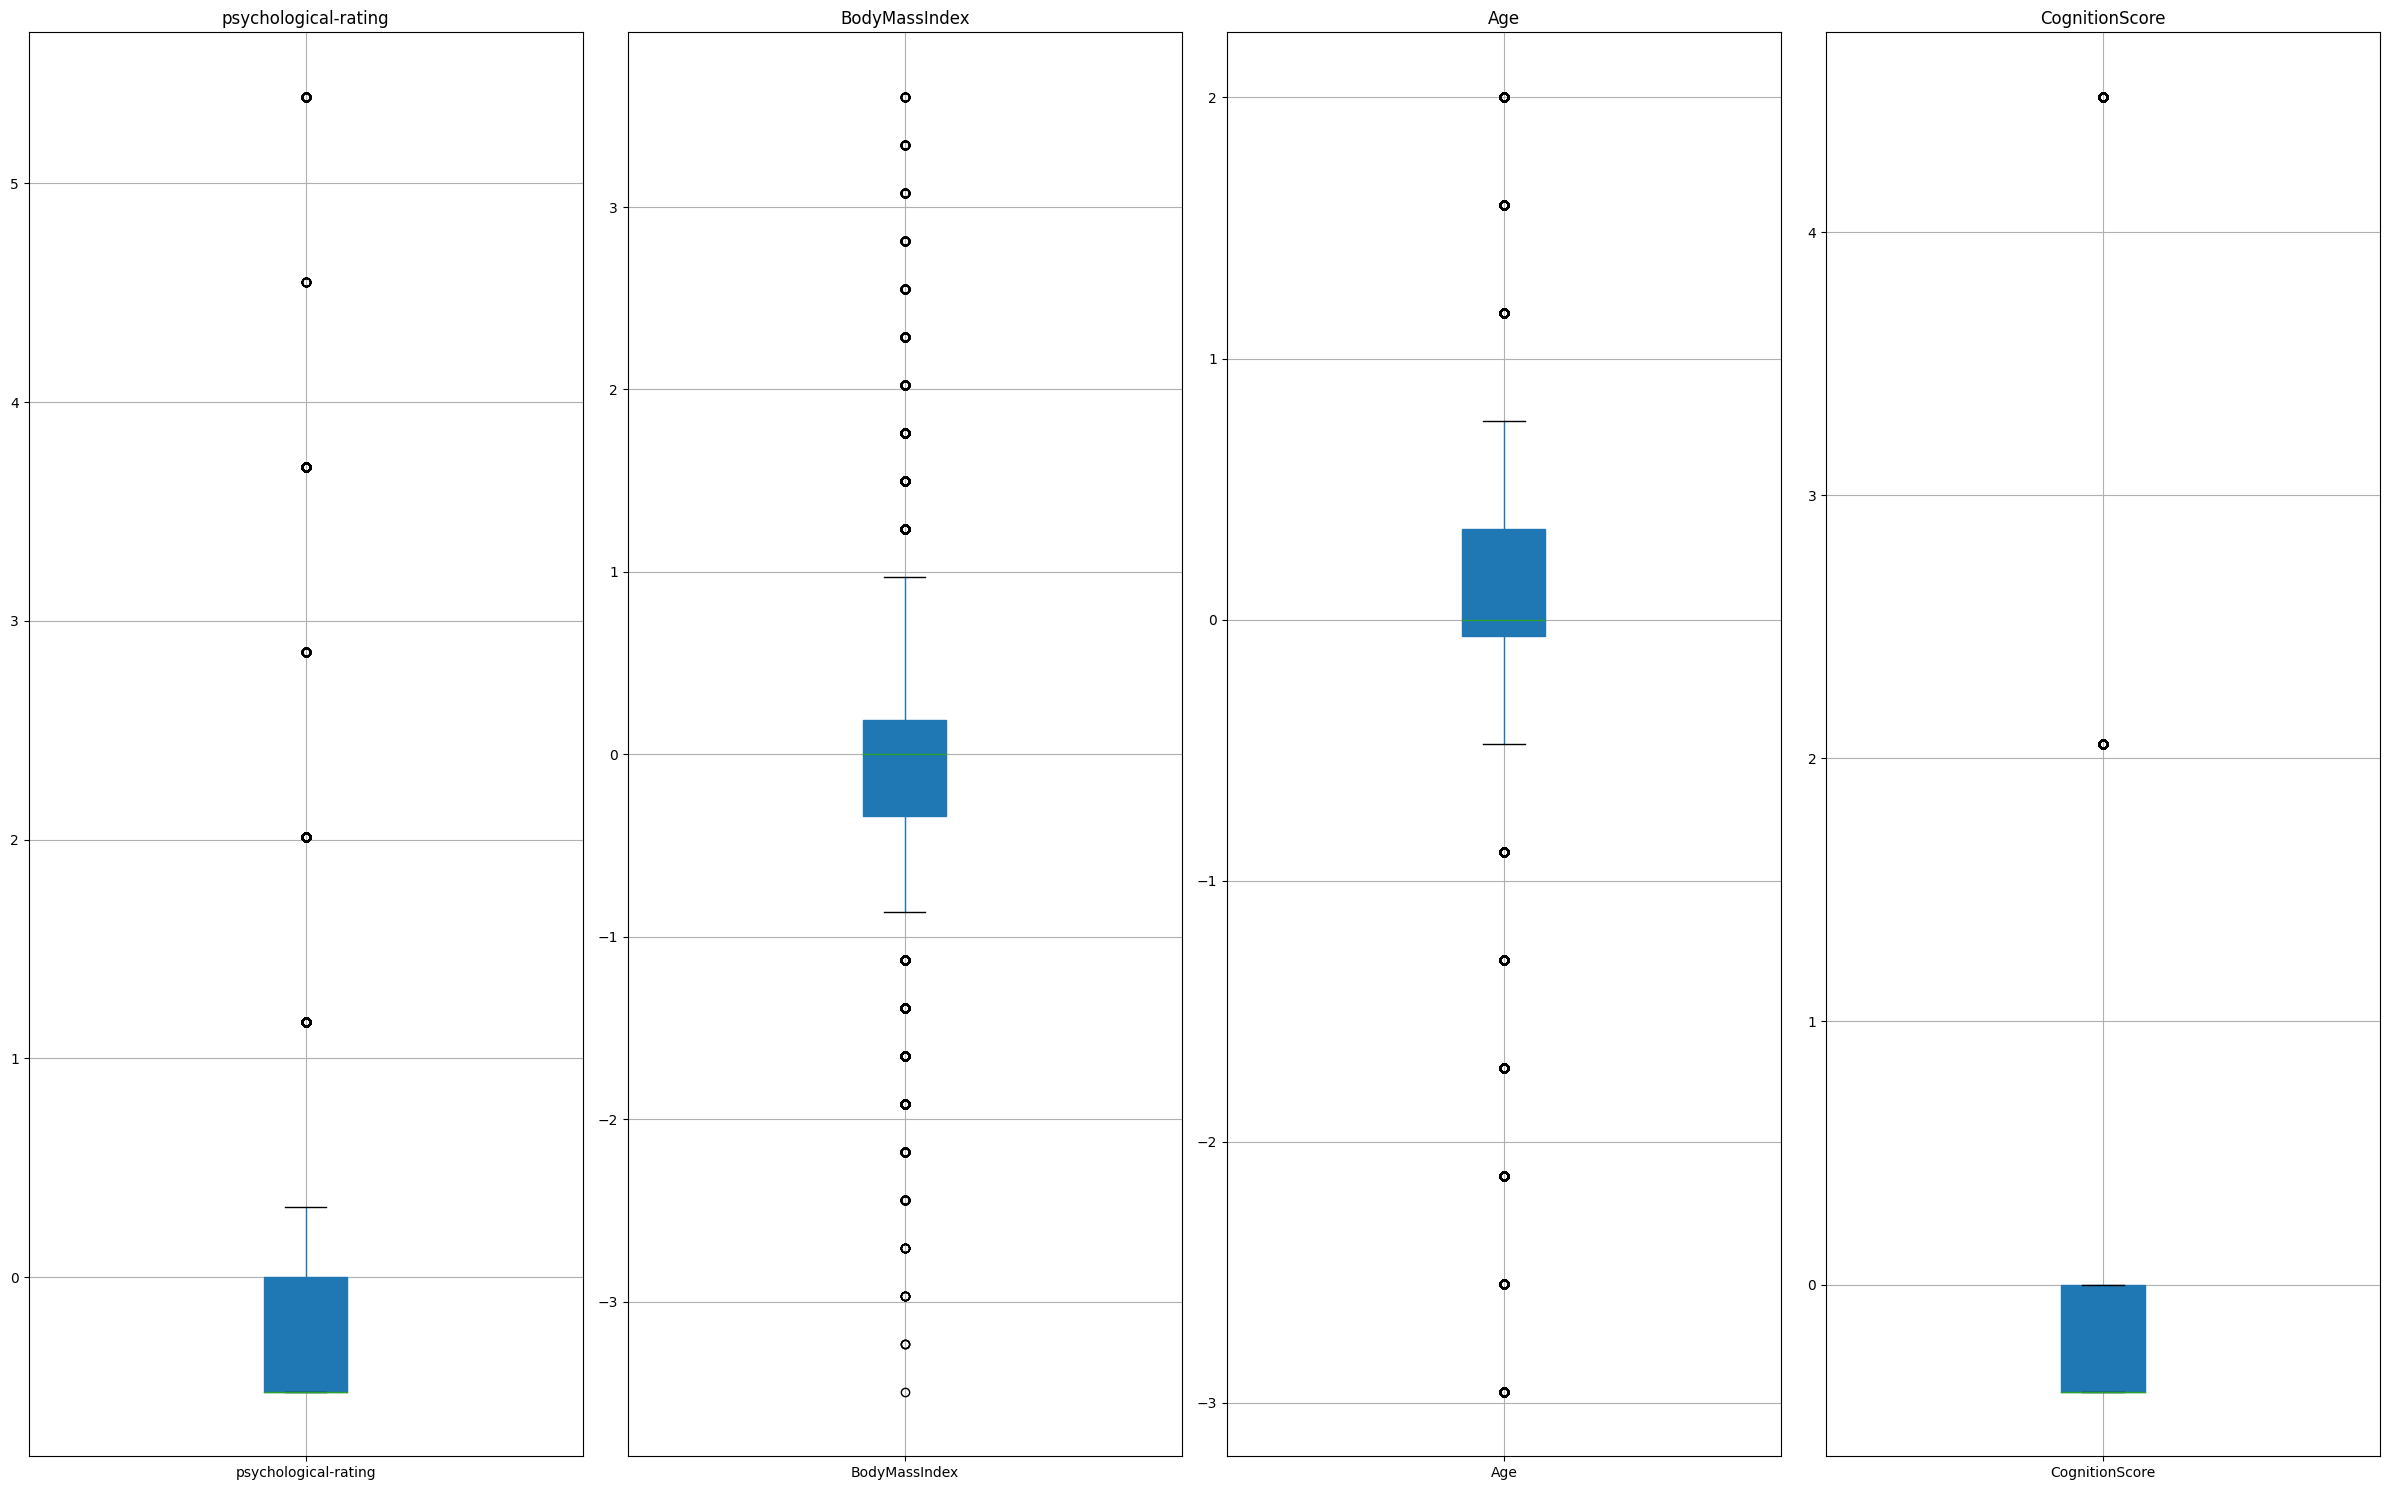

In [106]:
diabetes_full_set[diabetes_numerical_atributes_elimination] = normalize_numerical_attributes(diabetes_full_set, diabetes_numerical_atributes_elimination)
plot_numerical_attributes(diabetes_full_set, diabetes_numerical_atributes_elimination)

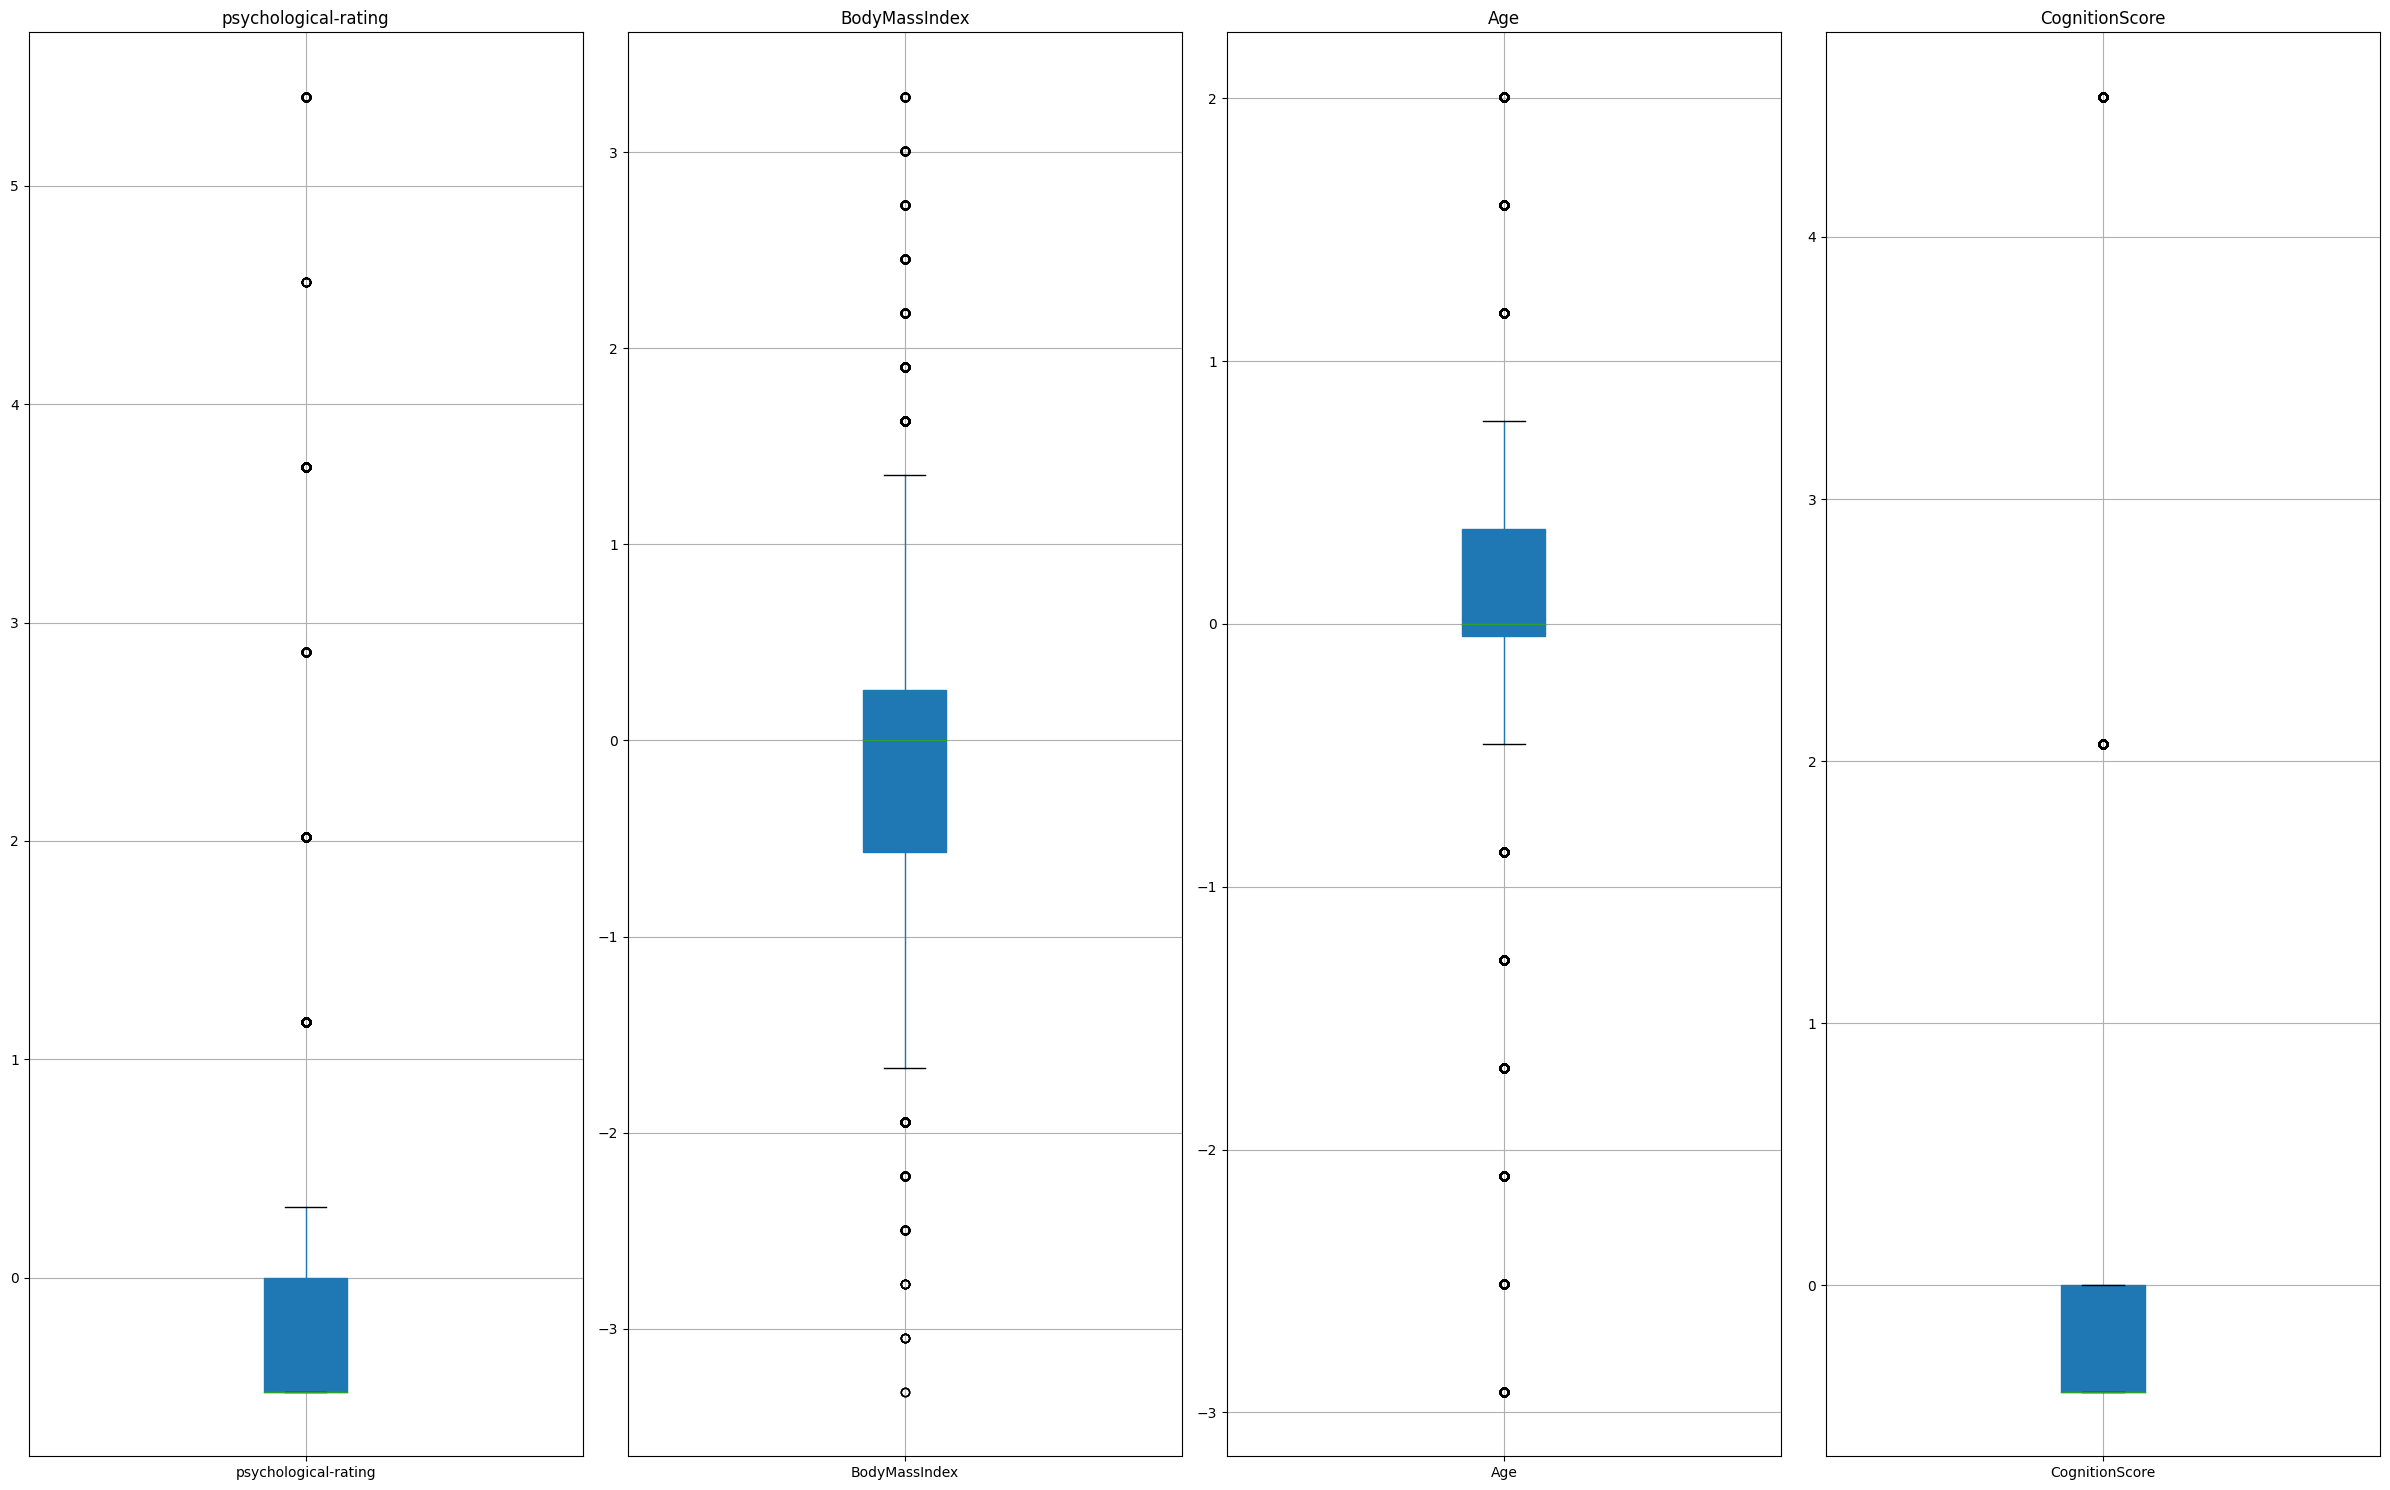

In [107]:
diabetes_train_set[diabetes_numerical_atributes_elimination] = normalize_numerical_attributes(diabetes_train_set, diabetes_numerical_atributes_elimination)
plot_numerical_attributes(diabetes_train_set, diabetes_numerical_atributes_elimination)

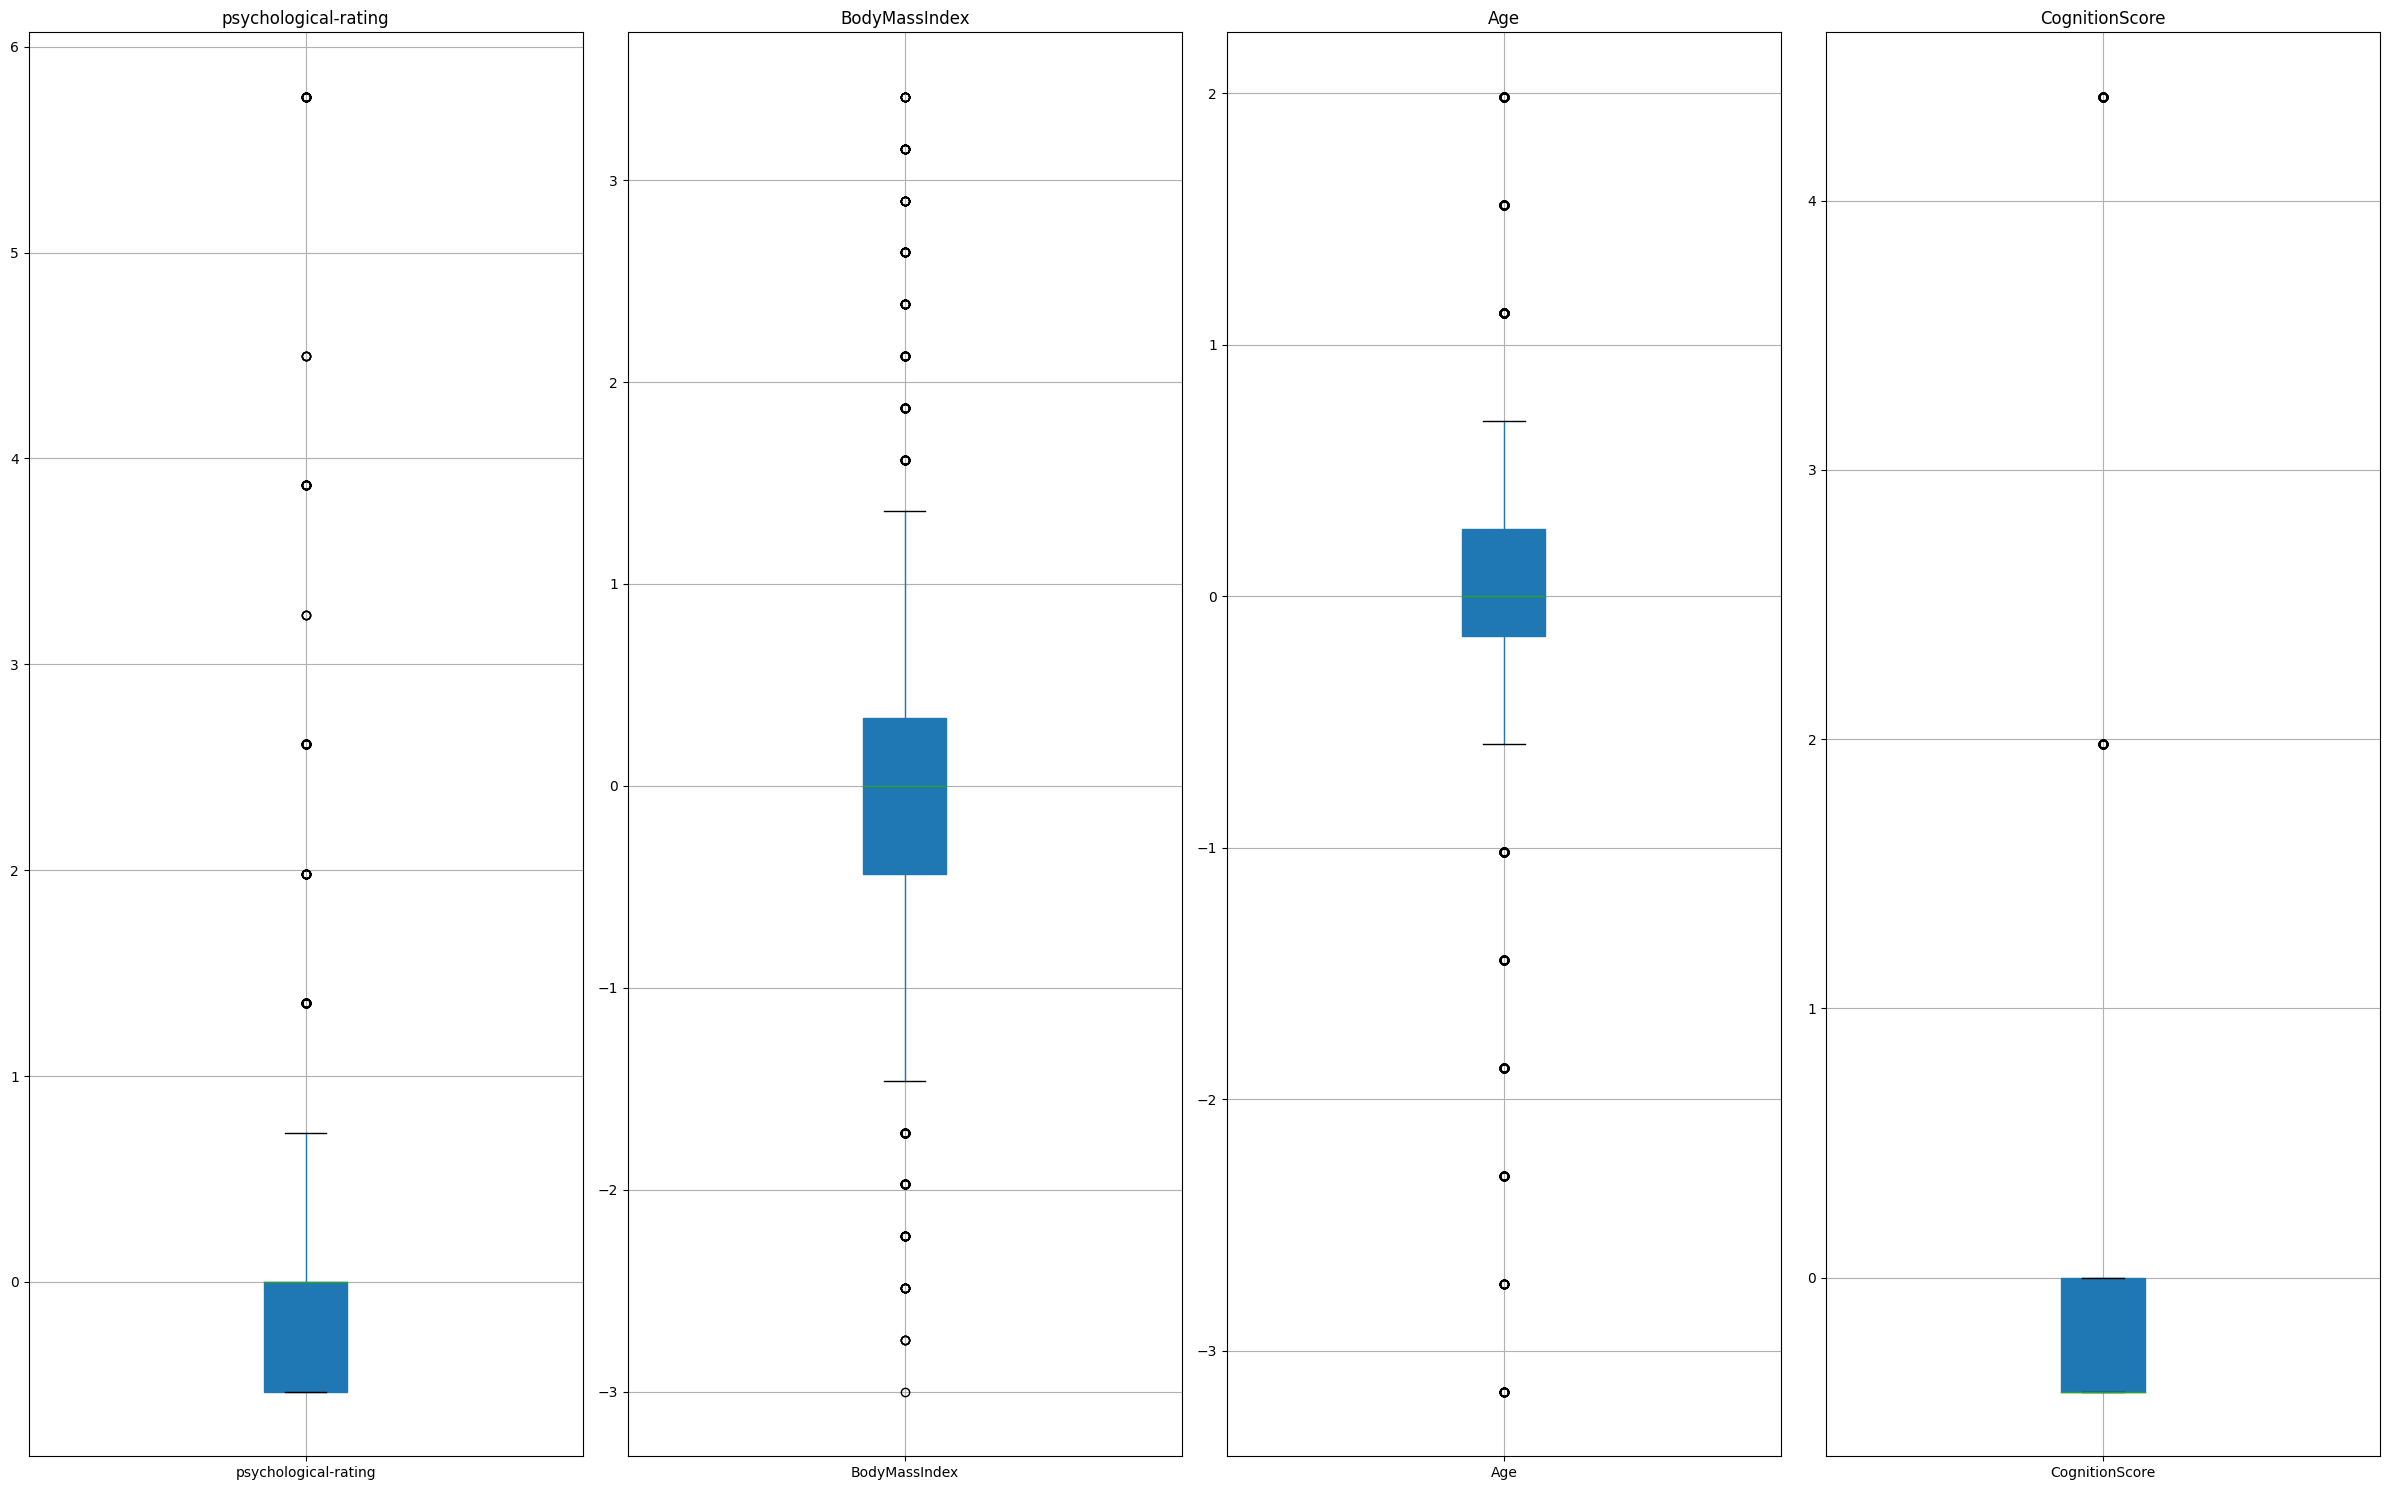

In [108]:
diabetes_test_set[diabetes_numerical_atributes_elimination] = normalize_numerical_attributes(diabetes_test_set, diabetes_numerical_atributes_elimination)
plot_numerical_attributes(diabetes_test_set, diabetes_numerical_atributes_elimination)

# Algorithms

# Random Forest

* Scikit-Learn implementation
  * Data encoding

In [109]:
def encode_data(dataset, attributes):
    encoder = LabelEncoder()
    for col in attributes:
        dataset[col] = encoder.fit_transform(dataset[col])
    return dataset[attributes]

diabetes_full_set[discrete_ordinal_attributes_list_elimination] = encode_data(diabetes_full_set, discrete_ordinal_attributes_list_elimination)
diabetes_train_set[discrete_ordinal_attributes_list_elimination] = encode_data(diabetes_train_set, discrete_ordinal_attributes_list_elimination)
diabetes_test_set[discrete_ordinal_attributes_list_elimination] = encode_data(diabetes_test_set, discrete_ordinal_attributes_list_elimination)

* Random Forest Classifier 

In [110]:
def find_best_parameters(train, test, attributes, label, classifier):
    n_estimators = [int(x) for x in np.linspace(start=50, stop=200, num=10)]
    max_features = ['sqrt', 'log2', None]
    max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    class_weight = ['balanced', 'balanced_subsample', None]

    random_grid = {
        'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap,
        'class_weight': class_weight
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    rf_random = RandomizedSearchCV(estimator=classifier,
                                   param_distributions=random_grid,
                                   n_iter=10,
                                   cv=skf,
                                   random_state=42,
                                   n_jobs=-1,
                                   scoring='f1')

    rf_random = rf_random.fit(train[attributes], train[label])

    return rf_random.best_estimator_.predict(test[attributes]), rf_random.best_params_

C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


{'n_estimators': 133, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 110, 'class_weight': 'balanced_subsample', 'bootstrap': False}
              precision    recall  f1-score   support

           0       0.81      0.67      0.74      1446
           1       0.06      0.19      0.09        54
           2       0.40      0.50      0.44       500

    accuracy                           0.62      2000
   macro avg       0.42      0.45      0.42      2000
weighted avg       0.69      0.62      0.65      2000

F1 score: 0.6458955161994383
Precision score: 0.6877184887275626
Recall score: 0.6175
Accuracy score: 0.6175


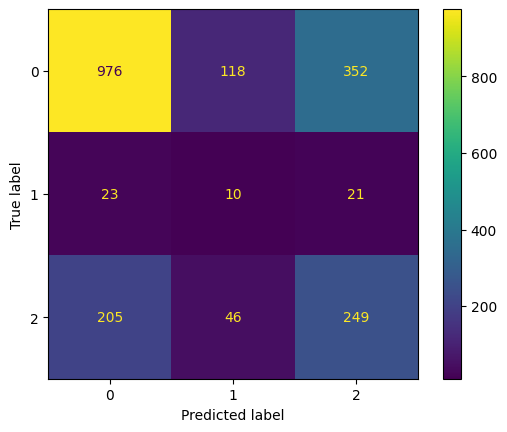

In [111]:
classifier = RandomForestClassifier(random_state=42)
predictions, best_params = find_best_parameters(diabetes_train_set, diabetes_test_set, diabetes_numerical_atributes_elimination + discrete_ordinal_attributes_list_elimination, 'Diabetes', classifier)

print(best_params)
print(classification_report(diabetes_test_set['Diabetes'], predictions))
print(f"F1 score: {f1_score(diabetes_test_set['Diabetes'], predictions, average='weighted')}")
print(f"Precision score: {precision_score(diabetes_test_set['Diabetes'], predictions, average='weighted')}")
print(f"Recall score: {recall_score(diabetes_test_set['Diabetes'], predictions, average='weighted')}")
print(f"Accuracy score: {accuracy_score(diabetes_test_set['Diabetes'], predictions)}")
ConfusionMatrixDisplay(confusion_matrix(diabetes_test_set['Diabetes'], predictions)).plot()

* Random Forest Implementation

In [112]:
class DecisionTreeNode:
    def __init__(self, 
                 feature: Optional[str] = None, 
                 children: Optional[Dict[str, 'DecisionTreeNode']] = None, 
                 label: Optional[str] = None):
        self.split_feature = feature
        self.children = children if (children is not None and feature is not None) else {}
        self.label = label
        self.depth = 1
        self.score = 0
        self.num_samples = 0

    def get_tree_graph(self,
                       graph: Digraph = None) -> Digraph:
        if graph is None:
            graph = Digraph()
            graph.attr('node', shape='box')

        if self.split_feature is None:
            graph.node(f"{self}", f"Label: {self.label}\n"
                                  f"Score: {self.score:.3f}\n"
                                  f"Samples: {self.num_samples}", 
                       fillcolor='darkolivegreen2', style='filled')
        else:
            graph.node(f"{self}", f"Split: {self.split_feature}?\n"
                                  f"Score: {self.score:.3f}\n"
                                  f"Samples: {self.num_samples}", fillcolor='lightblue', style='filled')

            for value, child in self.children.items():
                child.get_tree_graph(graph)
                graph.edge(f"{self}", f"{child}", label=f"{value}")

        return graph

    def display(self):
        graph = self.get_tree_graph()
        idisplay(Source(graph.source))

In [113]:
from typing import Callable

class DecisionTree:
    def __init__(self,
                 split_strategy: str = 'random',
                 max_depth: int = np.inf,
                 min_samples_per_node: int = 1):
        self._root: DecisionTreeNode | None = None # Rădăcina arborelui
        self._split_strategy: str = split_strategy
        self._max_depth: int = max_depth
        self._min_samples_per_node: int = min_samples_per_node

    @staticmethod
    def most_frequent_class(y: pd.Series) -> str:
        return y.mode().values[0]

    @staticmethod
    def compute_entropy(y: pd.Series) -> float:
        counts = y.value_counts()
        return - counts / len(y) @ np.log2(counts / len(y))

    @staticmethod
    def compute_information_gain(X: pd.DataFrame, y: pd.Series, feature: str) -> float:
        entropyi = DecisionTree.compute_entropy(y)
        entropyf = 0
        examples = X[feature]
        for value in examples.unique():
            entropyf += len(X[X[feature] == value]) / len(X) * DecisionTree.compute_entropy(y[examples == value])
        return entropyi - entropyf

    def _select_random_split_feature(self, X: pd.DataFrame, y: pd.Series, attribute_list: list[str]) -> str:
        return np.random.choice(attribute_list)

    def _select_best_split_feature(self, X: pd.DataFrame, y: pd.Series, attribute_list: list[str]) -> str:
        gains = [(attribute, DecisionTree.compute_information_gain(X, y, attribute)) for attribute in attribute_list]
        max_index = np.argmax([gain for _, gain in gains])
        return gains[max_index][0]

    def _generate_tree(self,
                       parent_node: DecisionTreeNode | None,
                       X: pd.DataFrame,
                       y: pd.Series,
                       feature_list: list[str],
                       select_feature_func: Callable[[pd.DataFrame, pd.Series, list[str]], str]) -> DecisionTreeNode:
        feature_list = deepcopy(feature_list)

        node = DecisionTreeNode()
        node.depth = parent_node.depth + 1 if parent_node is not None else 0
        node.score = DecisionTree.compute_entropy(y)  
        node.num_samples = len(y)
        node.label = DecisionTree.most_frequent_class(y)

        if len(feature_list) == 0 or node.depth >= self._max_depth or len(y) < self._min_samples_per_node or y.nunique() == 1:
            return node

        split_feature = select_feature_func(X, y, feature_list)
        feature_list.remove(split_feature)
        node.split_feature = split_feature
        for value in X[split_feature].unique():
            node.children[value] = self._generate_tree(node, X[X[split_feature] == value], y[X[split_feature] == value], feature_list, select_feature_func)

        return node

    def fit(self, X: pd.DataFrame, y: pd.Series):
        if self._split_strategy == 'random':
            select_feature_func = self._select_random_split_feature
        elif self._split_strategy == 'id3':
            select_feature_func = self._select_best_split_feature
        else:
            raise ValueError(f"Unknown split strategy {self._split_strategy}")

        self._root = self._generate_tree(parent_node=None,
                                         X=X,
                                         y=y,
                                         feature_list=X.columns.tolist(),
                                         select_feature_func=select_feature_func)

    def _predict_once(self, x: pd.Series) -> str:
        node = self._root

        while node.split_feature is not None:
            if node.split_feature in x and x[node.split_feature] in node.children:
                node = node.children[x[node.split_feature]]
            else:
                break
        return node.label

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        return np.array([self._predict_once(x) for _, x in X.iterrows()])

    def get_depth(self) -> int:
        def _get_depth(node: DecisionTreeNode) -> int:
            if node is None:
                return 0
            return max([_get_depth(child) for child in node.children.values()], default=0) + 1

        return _get_depth(self._root)

    def get_number_of_nodes(self) -> int:
        def _get_number_of_nodes(node: DecisionTreeNode) -> int:
            if node is None:
                return 0
            return sum([_get_number_of_nodes(child) for child in node.children.values()], 0) + 1

        return _get_number_of_nodes(self._root)

    def get_tree_graph(self) -> Digraph:
        return self._root.get_tree_graph()

    def display(self):
        return self._root.display()

In [114]:
from typing import Counter

class RandomForest:
    def __init__(self,
                 n_estimators: int = 100,
                 max_depth: int = 3,
                 min_samples_per_node: int = 1,
                 split_strategy: str = 'random',
                 subset_size_ratio: float = 0.5,
                 subset_feature_ratio: float = 0.75):
        assert 0 < subset_size_ratio <= 1, "subset_size_ratio must be between 0 and 1"
        assert 0 < subset_feature_ratio <= 1, "subset_feature_ratio must be between 0 and 1"

        self._trees: list[DecisionTree] = []
        self._n_estimators: int = n_estimators
        self._max_depth: int = max_depth
        self._min_samples_per_node: int = min_samples_per_node
        self._split_strategy: str = split_strategy
        self._subset_size_ratio: float = subset_size_ratio
        self._subset_feature_ratio: float = subset_feature_ratio

    def fit(self, X: pd.DataFrame, y: pd.Series):
            indices = np.random.choice(X.shape[0], size=int(self._subset_size_ratio * X.shape[0]), replace=False)
            X_subset = X.iloc[indices]
            y_subset = y.iloc[indices]
            features = np.random.choice(X.columns, size=int(self._subset_feature_ratio * X.shape[1]), replace=False)
            tree = DecisionTree(split_strategy=self._split_strategy,
                                max_depth=self._max_depth,
                                min_samples_per_node=self._min_samples_per_node)
            tree.fit(X_subset[features], y_subset)
            self._trees.append(tree)

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        predictions = []

        for tree in self._trees:
            predictions.append(tree.predict(X))

        return np.array([Counter(pred).most_common(1)[0][0] for pred in np.array(predictions).T])

    def display(self, max_trees: int = 5):
        for i, tree in enumerate(self._trees[:max_trees]):
            print()
            tree.display()

    def get_params(self, deep=True):
        return {
            'n_estimators': self._n_estimators,
            'max_depth': self._max_depth,
            'min_samples_per_node': self._min_samples_per_node,
            'split_strategy': self._split_strategy,
            'subset_size_ratio': self._subset_size_ratio,
            'subset_feature_ratio': self._subset_feature_ratio
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

In [115]:
def categorize_numerical_attributes(dataset, attributes, bins):
    for attribute in attributes:
        dataset[attribute] = pd.cut(dataset[attribute], bins=bins, labels=False, duplicates='drop')
    return dataset[attributes]

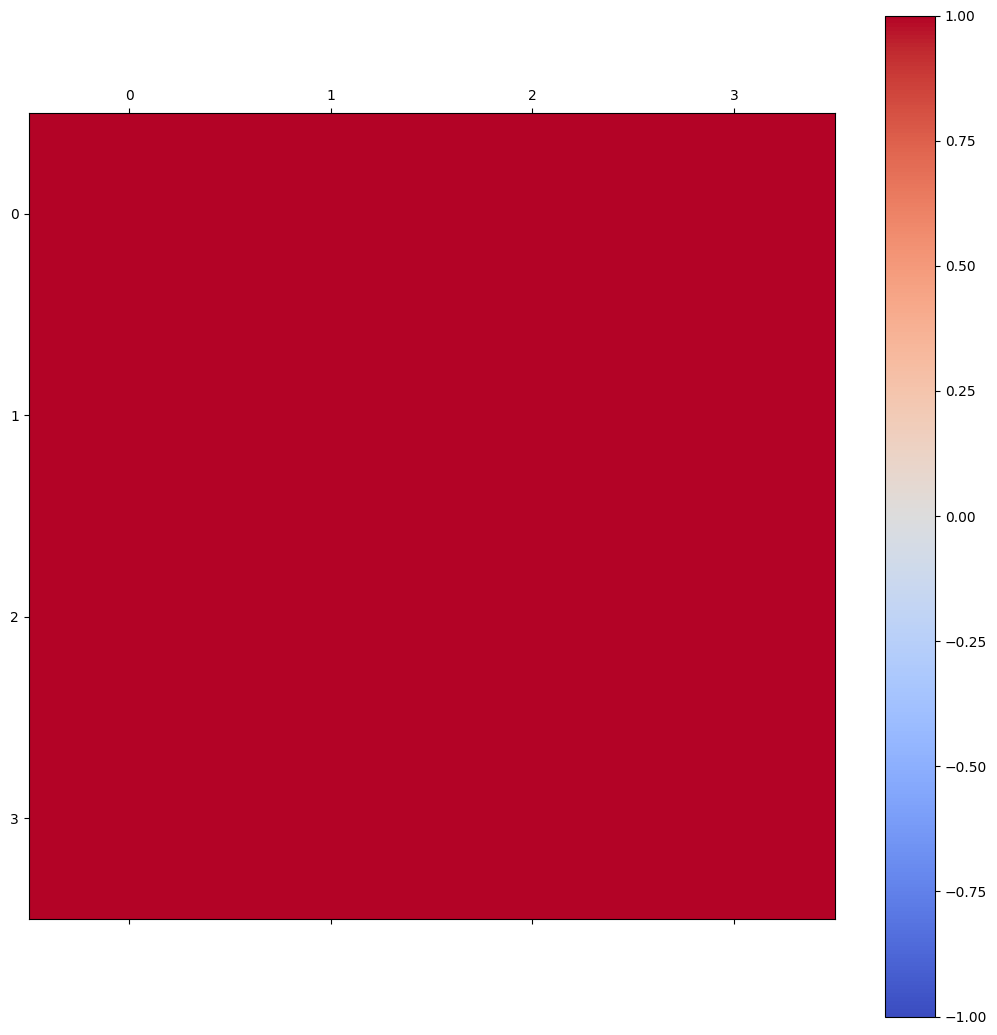

In [116]:
diabetes_full_set_aux = deepcopy(diabetes_full_set)
diabetes_train_set_aux = deepcopy(diabetes_train_set)
diabetes_test_set_aux = deepcopy(diabetes_test_set)

diabetes_full_set[diabetes_numerical_atributes_elimination] = categorize_numerical_attributes(diabetes_full_set, diabetes_numerical_atributes_elimination, 5)
diabetes_train_set[diabetes_numerical_atributes_elimination] = categorize_numerical_attributes(diabetes_train_set, diabetes_numerical_atributes_elimination, 2)
diabetes_test_set[diabetes_numerical_atributes_elimination] = categorize_numerical_attributes(diabetes_test_set, diabetes_numerical_atributes_elimination, 3)

corr_matrix = get_corr_matrix_discrete_ordinal_attributes(diabetes_train_set, diabetes_numerical_atributes_elimination)
plot_heat_map(corr_matrix)

In [117]:
random_forest = RandomForest(n_estimators=250, max_depth=150, min_samples_per_node=2, split_strategy='id3')

random_forest.fit(diabetes_train_set[discrete_ordinal_attributes_list], diabetes_train_set['Diabetes'])
predictions = random_forest.predict(diabetes_test_set[discrete_ordinal_attributes_list])

              precision    recall  f1-score   support

           0       0.74      0.97      0.84      1446
           1       0.18      0.04      0.06        54
           2       0.52      0.08      0.14       500

    accuracy                           0.72      2000
   macro avg       0.48      0.36      0.35      2000
weighted avg       0.67      0.72      0.64      2000

F1 score: 0.6435395693687092
Precision score: 0.6669365192808588
Recall score: 0.7245
Accuracy score: 0.7245


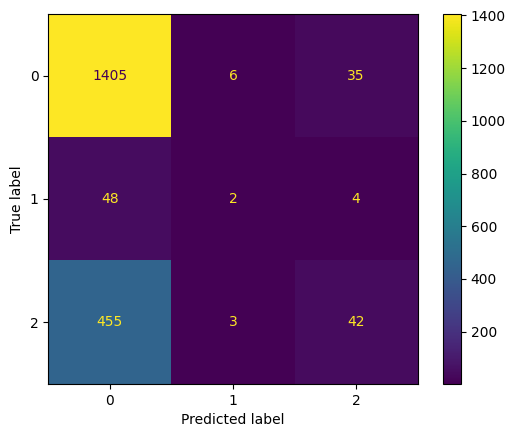

In [118]:
print(classification_report(diabetes_test_set['Diabetes'], predictions))
print(f"F1 score: {f1_score(diabetes_test_set['Diabetes'], predictions, average='weighted')}")
print(f"Precision score: {precision_score(diabetes_test_set['Diabetes'], predictions, average='weighted')}")
print(f"Recall score: {recall_score(diabetes_test_set['Diabetes'], predictions, average='weighted')}")
print(f"Accuracy score: {accuracy_score(diabetes_test_set['Diabetes'], predictions)}")
ConfusionMatrixDisplay(confusion_matrix(diabetes_test_set['Diabetes'], predictions)).plot()

# MLP

MLP classifier

C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


{'solver': 'adam', 'max_iter': 500, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'alpha': 0.001, 'activation': 'relu'}
              precision    recall  f1-score   support

           0       0.76      0.95      0.84      1446
           1       0.00      0.00      0.00        54
           2       0.57      0.23      0.33       500

    accuracy                           0.74      2000
   macro avg       0.44      0.39      0.39      2000
weighted avg       0.69      0.74      0.69      2000

F1 score: 0.6926617572763759
Precision: 0.6933788370897718
Recall: 0.7415
Accuracy: 0.7415


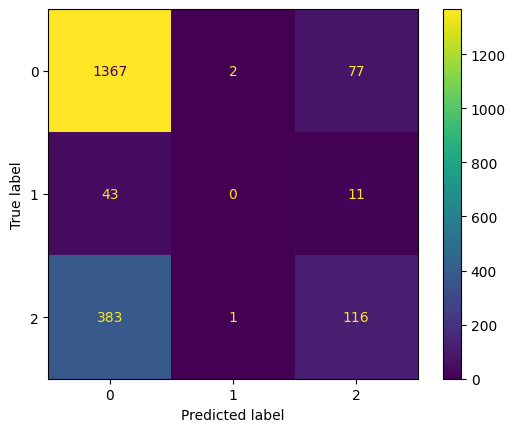

In [119]:
from sklearn.neural_network import MLPClassifier

def find_best_parameters_mlp(train, test, attributes, label):
    mlp = MLPClassifier()

    param_dist = {
        'hidden_layer_sizes': [(50,), (100,), (150,), (200,), (250,)],
        'activation': ['logistic', 'tanh', 'relu'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'max_iter': [200, 300, 400, 500]
    }

    random_search = RandomizedSearchCV(mlp, param_distributions=param_dist, n_iter=10, cv=3, scoring='f1', n_jobs=-1, random_state=42)
    random_search.fit(train[attributes], train[label])

    best_params = random_search.best_params_

    best_model = MLPClassifier(**best_params)
    best_model.fit(train[attributes], train[label])

    predictions = best_model.predict(test[attributes])

    return predictions, best_params

diabetes_train_set[discrete_ordinal_attributes_list] = encode_data(diabetes_train_set, discrete_ordinal_attributes_list)
diabetes_test_set[discrete_ordinal_attributes_list] = encode_data(diabetes_test_set, discrete_ordinal_attributes_list)

diabetes_train_set_aux[discrete_ordinal_attributes_list] = encode_data(diabetes_train_set_aux, discrete_ordinal_attributes_list)
diabetes_test_set_aux[discrete_ordinal_attributes_list] = encode_data(diabetes_test_set_aux, discrete_ordinal_attributes_list)

predictions, best_params = find_best_parameters_mlp(diabetes_train_set_aux, diabetes_test_set_aux, diabetes_numerical_atributes_elimination + discrete_ordinal_attributes_list, 'Diabetes')

print(best_params)

print(classification_report(diabetes_test_set_aux['Diabetes'], predictions))
print(f"F1 score: {f1_score(diabetes_test_set_aux['Diabetes'], predictions, average='weighted')}")
print(f"Precision: {precision_score(diabetes_test_set_aux['Diabetes'], predictions, average='weighted')}")
print(f"Recall: {recall_score(diabetes_test_set_aux['Diabetes'], predictions, average='weighted')}")
print(f"Accuracy: {accuracy_score(diabetes_test_set_aux['Diabetes'], predictions)}")
ConfusionMatrixDisplay(confusion_matrix(diabetes_test_set_aux['Diabetes'], predictions)).plot()

MLP Implementation

In [120]:
class Layer:
    def forward(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def update(self, *args, **kwargs):
        pass

In [121]:
from typing import List

class FeedForwardNetwork:

    def __init__(self, layers: List[Layer]):
        self.layers = layers

    def forward(self, x: np.ndarray, train: bool = True) -> np.ndarray:
        self._inputs = []
        for layer in self.layers:
            if train:
                self._inputs.append(x)
            x = layer.forward(x)
        return x

    def backward(self, dy: np.ndarray) -> np.ndarray:
        for layer, x in zip(reversed(self.layers), reversed(self._inputs)):
            dy = layer.backward(x, dy)

        return dy

    def update(self, *args, **kwargs):
        for layer in self.layers:
            layer.update(*args, **kwargs)

In [122]:
class Linear(Layer):
    def __init__(self, insize: int, outsize: int) -> None:
        bound = np.sqrt(6. / insize)
        self.weight = np.random.uniform(-bound, bound, (insize, outsize))
        self.bias = np.zeros((outsize,))

        self.dweight = np.zeros_like(self.weight)
        self.dbias = np.zeros_like(self.bias)

    def forward(self, x: np.ndarray) -> np.ndarray:
        return x @ self.weight + self.bias

    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        self.dweight = x.T @ dy
        for i in range(dy.shape[0]):
            self.dbias += dy[i]

        return dy @ self.weight.T

    def update(self, mode='SGD', lr=0.001, mu=0.9):
        if mode == 'SGD':
            self.weight -= lr * self.dweight
            self.bias -= lr * self.dbias
        else:
            raise ValueError('mode should be SGD, not ' + str(mode))

In [123]:
class ReLU(Layer):
    def __init__(self) -> None:
        pass

    def forward(self, x: np.ndarray) -> np.ndarray:
        return np.maximum(0, x)

    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        negatives = x < 0

        for i in range(dy.shape[0]):
            dy[i][negatives[i]] = 0
        return dy

In [124]:
class CrossEntropy:
    def __init__(self):
        pass

    def softmax(self, x):
        exps = np.exp(x)
        return exps / np.sum(exps,axis = 0)

    def forward(self, y: np.ndarray, t: np.ndarray) -> float:
        probs = self.softmax(y)
        new_probs = np.array([probs[i][t[i]] for i in range(len(t))])
        log_probs = -np.log(new_probs)
        return np.mean(log_probs)

    def backward(self, y: np.ndarray, t: np.ndarray) -> np.ndarray:
        prob = self.softmax(y)
        for i in range(len(t)):
            prob[i][t[i]] -= 1
        return prob / len(t)

Epoch 01 | Batch 062 | Train NLL:  4.114 | Train Acc:  40.62% | Test NLL:  8.366 | Test Acc: 28.45%
Epoch 02 | Batch 062 | Train NLL:  4.077 | Train Acc:  50.00% | Test NLL:  8.347 | Test Acc: 33.70%
Epoch 03 | Batch 062 | Train NLL:  4.043 | Train Acc:  62.50% | Test NLL:  8.329 | Test Acc: 43.80%
Epoch 04 | Batch 062 | Train NLL:  4.011 | Train Acc:  84.38% | Test NLL:  8.313 | Test Acc: 56.00%
Epoch 05 | Batch 062 | Train NLL:  3.982 | Train Acc:  93.75% | Test NLL:  8.299 | Test Acc: 65.25%
Epoch 06 | Batch 062 | Train NLL:  3.956 | Train Acc:  93.75% | Test NLL:  8.286 | Test Acc: 68.25%
Epoch 07 | Batch 062 | Train NLL:  3.935 | Train Acc:  96.88% | Test NLL:  8.277 | Test Acc: 70.25%
Epoch 08 | Batch 062 | Train NLL:  3.919 | Train Acc:  96.88% | Test NLL:  8.269 | Test Acc: 71.50%
Epoch 09 | Batch 062 | Train NLL:  3.907 | Train Acc:  96.88% | Test NLL:  8.264 | Test Acc: 71.95%
Epoch 10 | Batch 062 | Train NLL:  3.899 | Train Acc:  96.88% | Test NLL:  8.261 | Test Acc: 72.25%


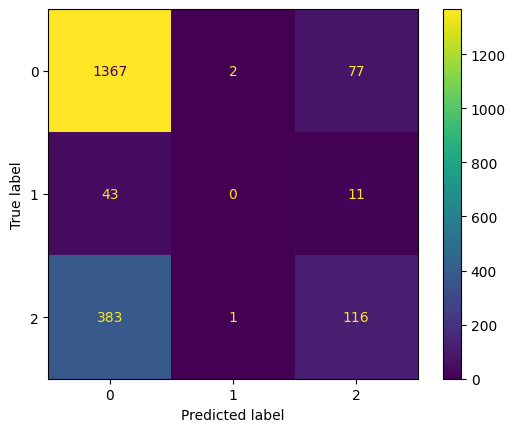

In [125]:
BATCH_SIZE = 32
HIDDEN_UNITS = 128
EPOCHS_NO = 20

diabetes_train_set[discrete_ordinal_attributes_list] = encode_data(diabetes_train_set, discrete_ordinal_attributes_list)
diabetes_test_set[discrete_ordinal_attributes_list] = encode_data(diabetes_test_set, discrete_ordinal_attributes_list)

def accuracy(y: np.ndarray, t: np.ndarray) -> float:
      return np.mean(np.argmax(y, axis=1) == t)

optimize_args = {'mode': 'SGD', 'lr': .00001}

net = FeedForwardNetwork([Linear(18, HIDDEN_UNITS),
                          ReLU(),
                          Linear(HIDDEN_UNITS,3 )])
cost_function = CrossEntropy()

for epoch in range(EPOCHS_NO):
    for b_no, idx in enumerate(range(0, len(diabetes_test_set_aux[discrete_ordinal_attributes_list]), BATCH_SIZE)):
        x = np.array(diabetes_train_set_aux[discrete_ordinal_attributes_list][idx:idx + BATCH_SIZE])
        t = np.array(diabetes_train_set_aux['Diabetes'][idx:idx + BATCH_SIZE])
        y = net.forward(x)
        loss = cost_function.forward(y, t)
        dy = cost_function.backward(y, t)
        net.backward(dy)

        net.update(**optimize_args)

        print(f'\rEpoch {epoch + 1:02d} '
              f'| Batch {b_no:03d} '
              f'| Train NLL: {loss:6.3f} '
              f'| Train Acc: {accuracy(y, t) * 100:6.2f}% ', end='')

    y = np.array(net.forward(diabetes_test_set_aux[discrete_ordinal_attributes_list], train=False))
    test_nll = cost_function.forward(y, diabetes_test_set_aux['Diabetes'])
    print(f'| Test NLL: {test_nll:6.3f} '
          f'| Test Acc: {accuracy(y, diabetes_test_set_aux["Diabetes"]) * 100:3.2f}%')
    
print(classification_report(diabetes_test_set_aux['Diabetes'], predictions))
print(f"F1 score: {f1_score(diabetes_test_set_aux['Diabetes'], predictions, average='weighted')}")
print(f"Precision: {precision_score(diabetes_test_set_aux['Diabetes'], predictions, average='weighted')}")
print(f"Recall: {recall_score(diabetes_test_set_aux['Diabetes'], predictions, average='weighted')}")
print(f"Accuracy: {accuracy_score(diabetes_test_set_aux['Diabetes'], predictions)}")
ConfusionMatrixDisplay(confusion_matrix(diabetes_test_set_aux['Diabetes'], predictions)).plot()

# Loan Approval Set

In [126]:
credit_risk_full_set[credit_risk_numerical_attributes_list].describe()

,applicant_age,applicant_income,job_tenure_years,loan_amount,loan_rate,loan_income_ratio,credit_history_length_years,credit_history_length_months
count,10000.000000,1.000000e+04,9736.000000,10000.000000,9060.000000,10000.000000,10000.000000,10000.000000
mean,27.745100,6.573421e+04,4.785744,9568.037500,11.007179,0.170130,5.811100,75.760700
std,6.360155,5.694439e+04,4.353122,6350.431581,3.266393,0.106814,4.050217,48.677362
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,25.000000
25%,23.000000,3.859500e+04,2.000000,5000.000000,7.900000,0.090000,3.000000,41.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.150000,4.000000,57.000000
75%,30.000000,7.899700e+04,7.000000,12200.000000,13.470000,0.230000,8.000000,102.000000
max,123.000000,2.039784e+06,123.000000,35000.000000,23.220000,0.760000,30.000000,369.000000


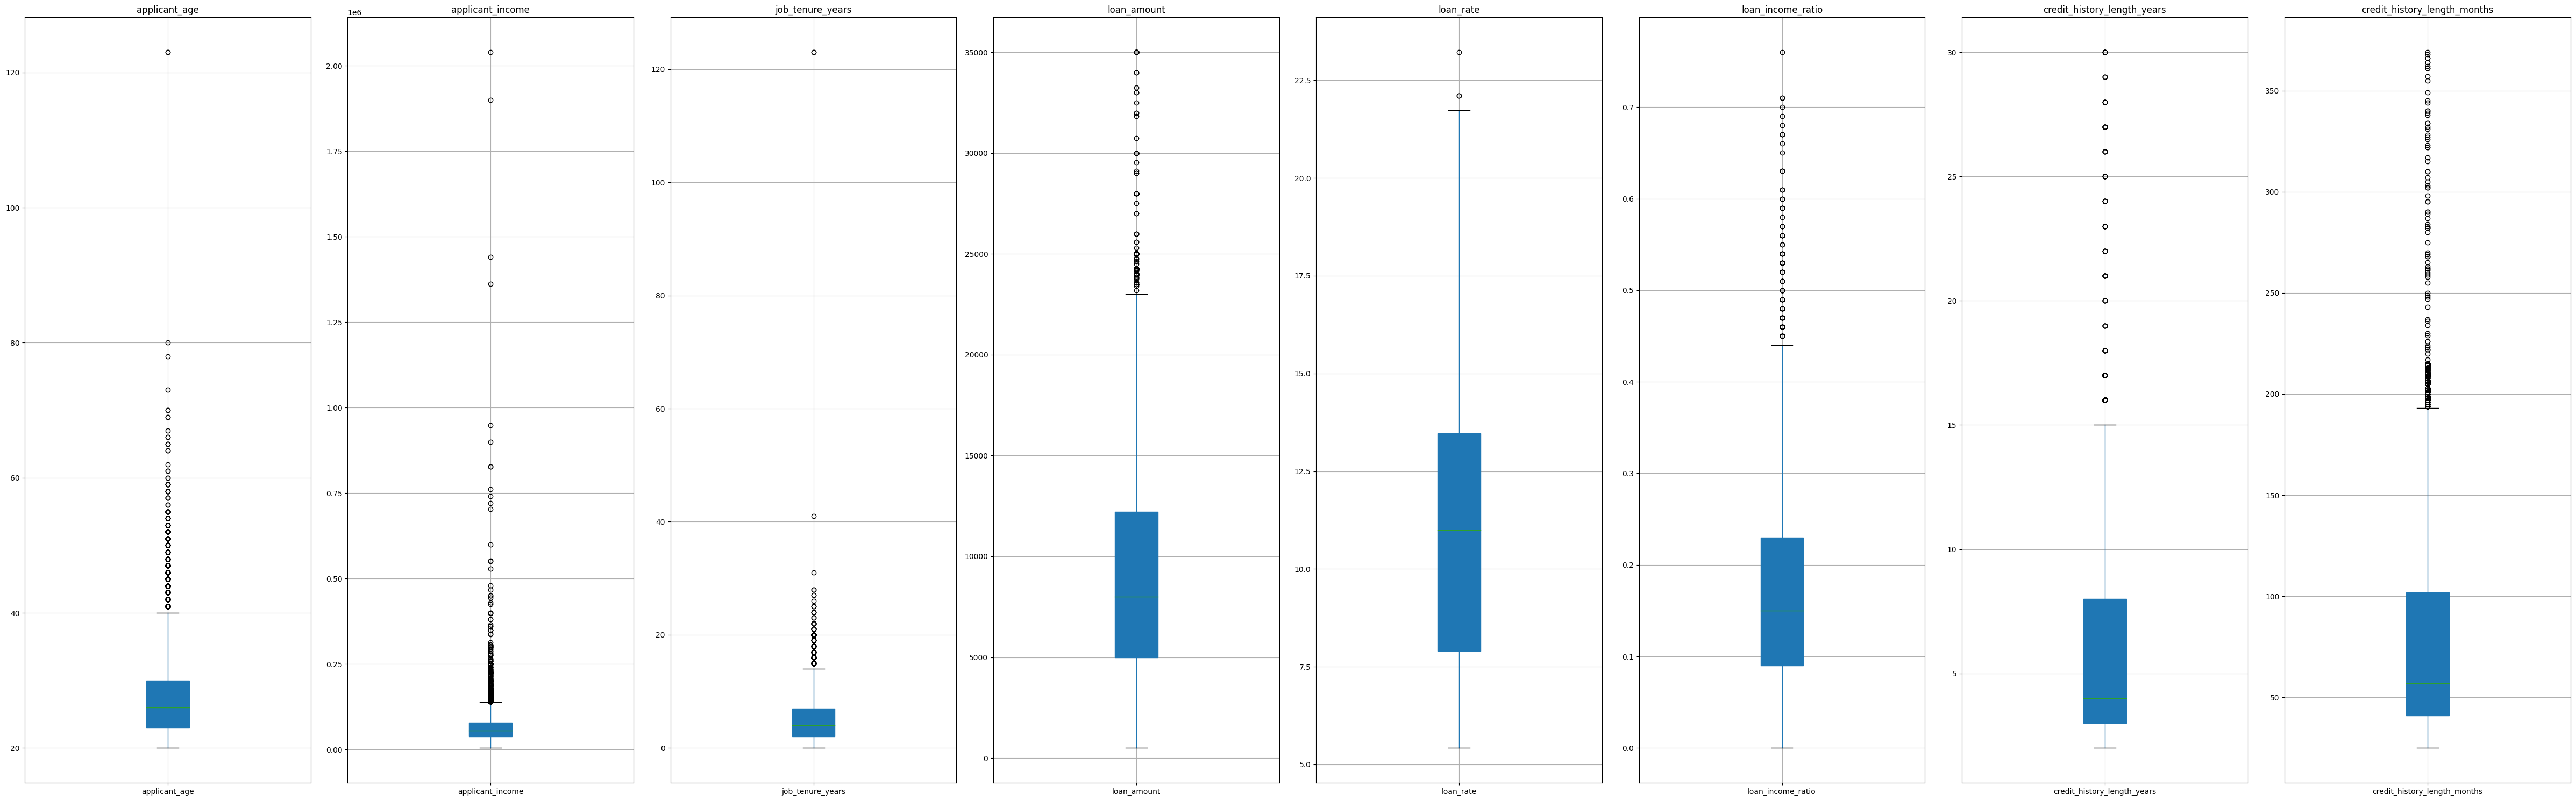

In [127]:
plot_numerical_attributes(credit_risk_full_set, credit_risk_numerical_attributes_list)

In [128]:
get_discrete_ordinal_attributes(credit_risk_full_set, credit_risk_ordinal_attributes_list)

,count,unique
residential_status,10000,4
loan_purpose,10000,6
loan_rating,10000,7
credit_history_default_status,10000,2
stability_rating,10000,4


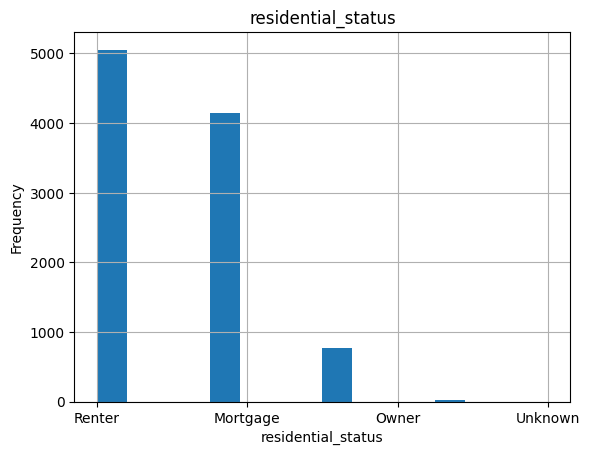

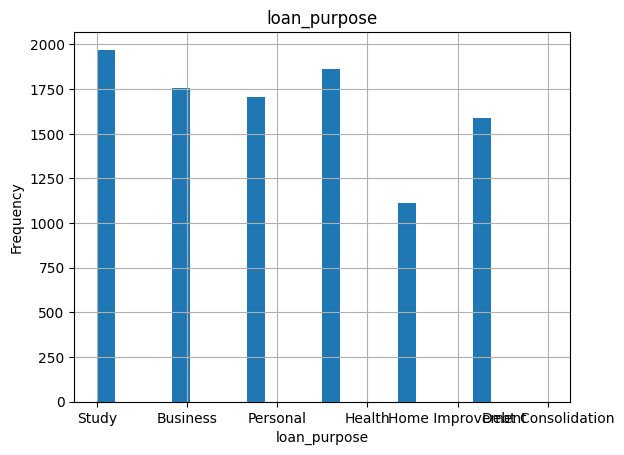

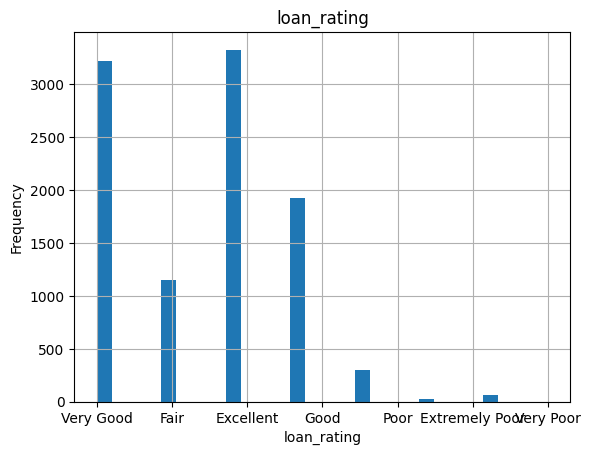

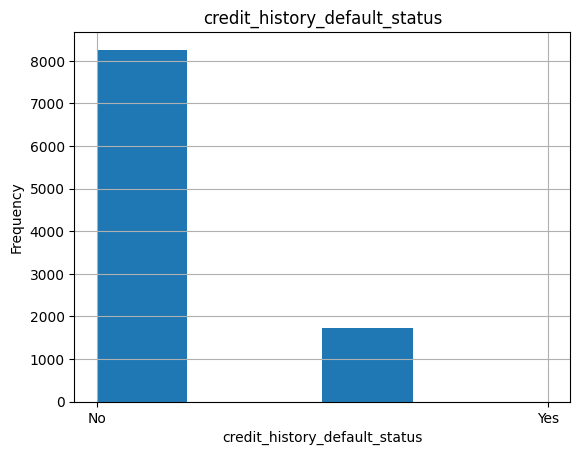

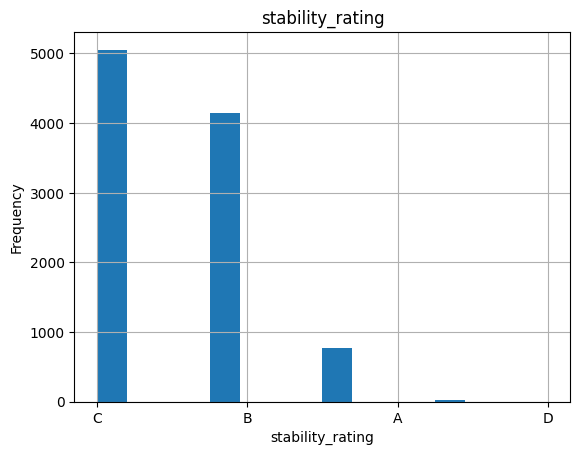

In [129]:
plot_discrete_ordinal_attributes(credit_risk_full_set, 
                                credit_risk_ordinal_attributes_list,
                                [
                                    0.2, 0.2, 0.2, 0.2, 0.2
                                ])

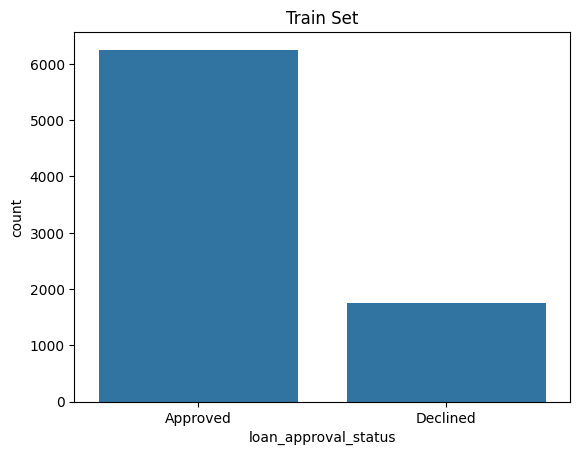

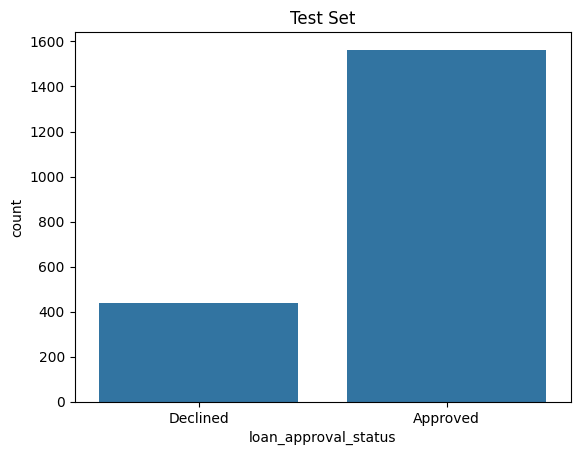

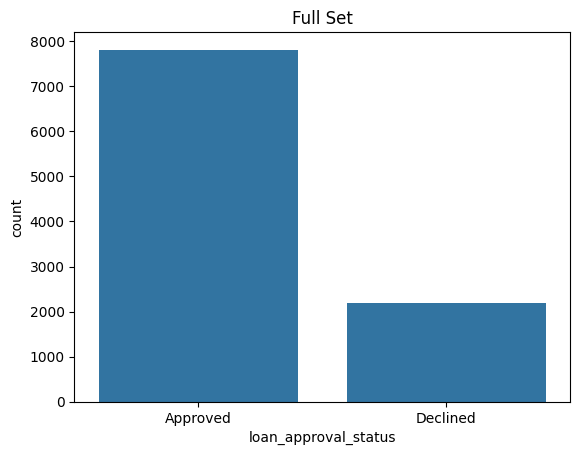

In [130]:
plot_labels([credits_risk_train_set, credits_risk_test_set, credit_risk_full_set], ['Train Set', 'Test Set', 'Full Set'], 'loan_approval_status')

In [131]:
corr_matrix = get_corr_matrix_numerical_attributes(credit_risk_full_set, credit_risk_numerical_attributes_list)
corr_matrix

,applicant_age,applicant_income,job_tenure_years,loan_amount,loan_rate,loan_income_ratio,credit_history_length_years,credit_history_length_months
applicant_age,1.000000,0.128489,0.135319,0.042126,0.008628,-0.034919,0.858263,0.856350
applicant_income,0.128489,1.000000,0.126753,0.279601,-0.000682,-0.271204,0.113971,0.114272
job_tenure_years,0.135319,0.126753,1.000000,0.112941,-0.057938,-0.049490,0.115380,0.115492
loan_amount,0.042126,0.279601,0.112941,1.000000,0.160547,0.577721,0.030215,0.030088
loan_rate,0.008628,-0.000682,-0.057938,0.160547,1.000000,0.132404,0.012147,0.011846
loan_income_ratio,-0.034919,-0.271204,-0.049490,0.577721,0.132404,1.000000,-0.032349,-0.032182
credit_history_length_years,0.858263,0.113971,0.115380,0.030215,0.012147,-0.032349,1.000000,0.997919
credit_history_length_months,0.856350,0.114272,0.115492,0.030088,0.011846,-0.032182,0.997919,1.000000


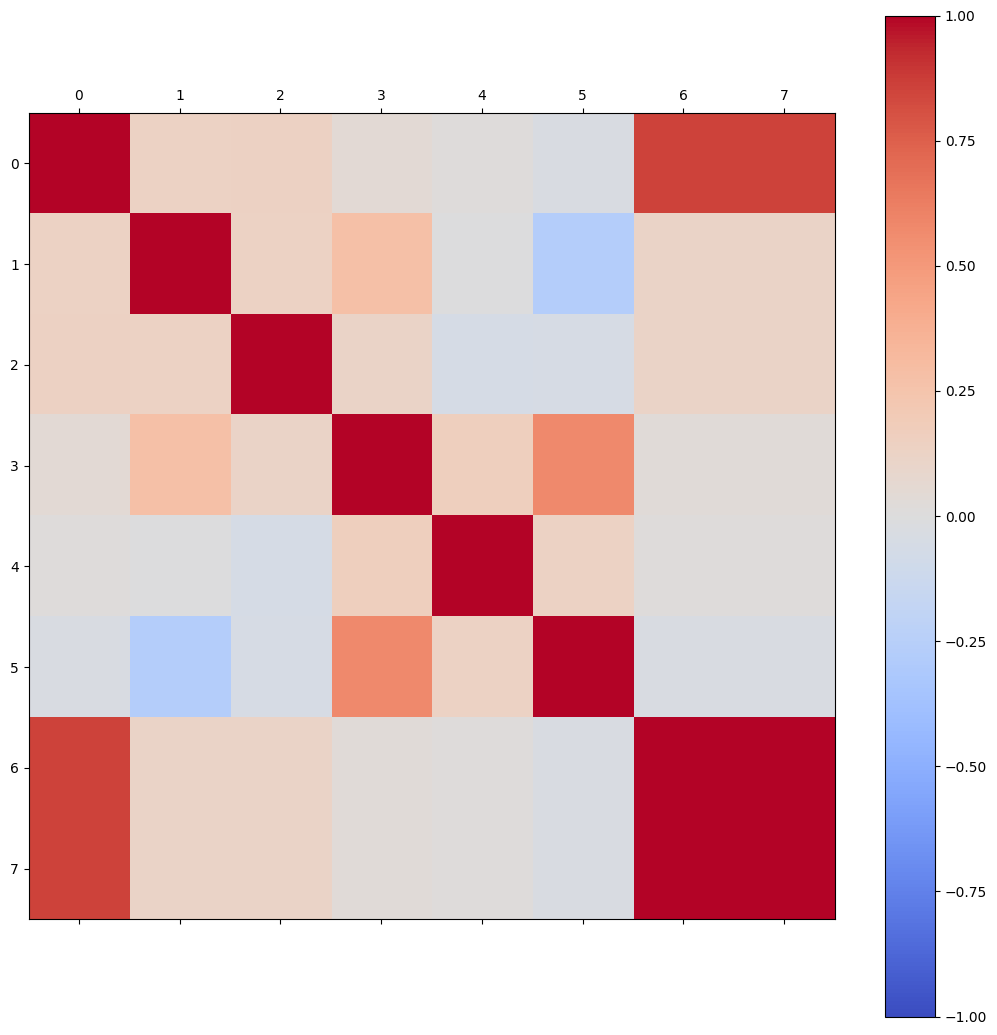

In [132]:
plot_heat_map(corr_matrix)

In [133]:
corr_matrix = get_corr_matrix_discrete_ordinal_attributes(credit_risk_full_set, credit_risk_ordinal_attributes_list)
corr_matrix

,residential_status,loan_purpose,loan_rating,credit_history_default_status,stability_rating
residential_status,1.000000,1.000000,1.000000,0.999945,1.000000
loan_purpose,1.000000,1.000000,0.846785,0.722777,1.000000
loan_rating,1.000000,0.846785,1.000000,1.000000,1.000000
credit_history_default_status,0.999945,0.722777,1.000000,1.000000,0.999945
stability_rating,1.000000,1.000000,1.000000,0.999945,1.000000


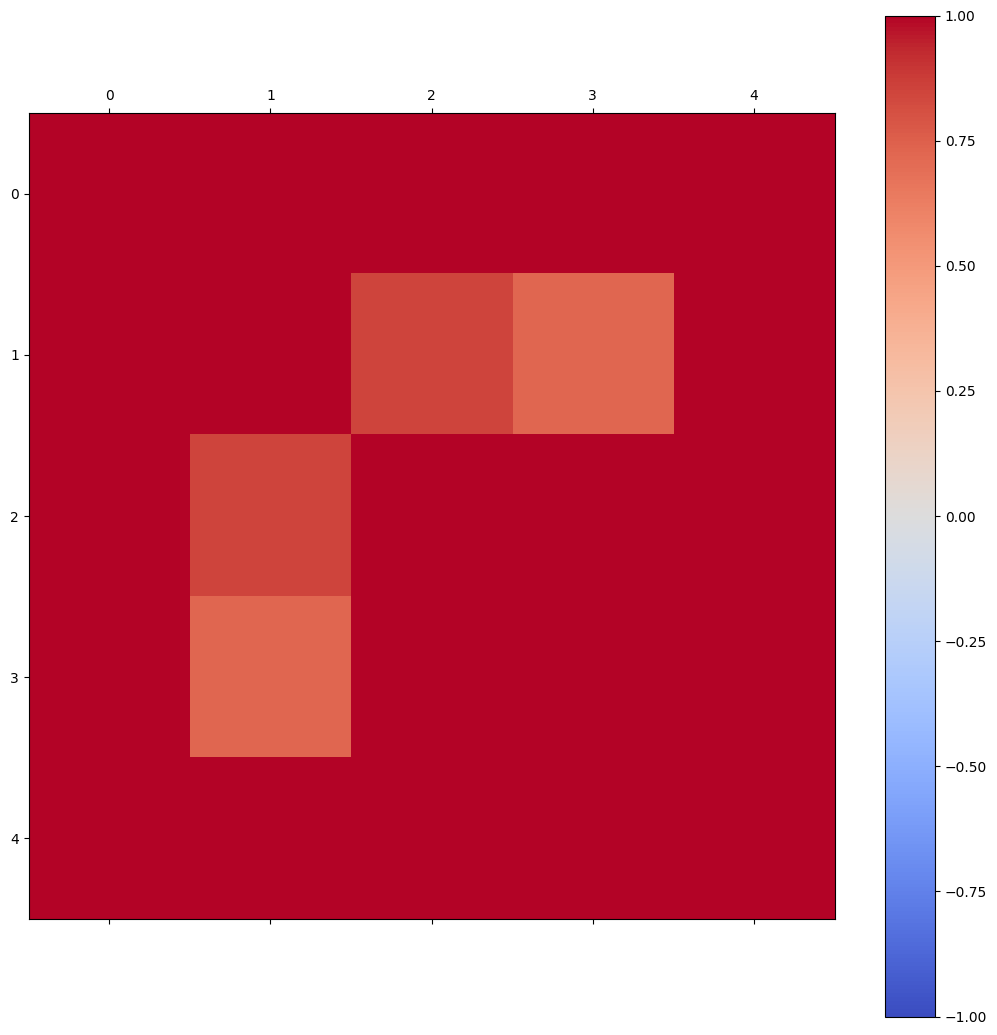

In [134]:
plot_heat_map(corr_matrix)

# Data Preprocessing

In [135]:
credit_risk_full_set[credit_risk_numerical_attributes_list] = get_missing_numerical_values(credit_risk_full_set, credit_risk_numerical_attributes_list)
credits_risk_train_set[credit_risk_numerical_attributes_list] = get_missing_numerical_values(credits_risk_train_set, credit_risk_numerical_attributes_list)
credits_risk_test_set[credit_risk_numerical_attributes_list] = get_missing_numerical_values(credits_risk_test_set, credit_risk_numerical_attributes_list)

In [136]:
credit_risk_full_set[credit_risk_ordinal_attributes_list] = get_missing_discrete_ordinal_values(credit_risk_full_set, credit_risk_ordinal_attributes_list)
credits_risk_train_set[credit_risk_ordinal_attributes_list] = get_missing_discrete_ordinal_values(credits_risk_train_set, credit_risk_ordinal_attributes_list)
credits_risk_test_set[credit_risk_ordinal_attributes_list] = get_missing_discrete_ordinal_values(credits_risk_test_set, credit_risk_ordinal_attributes_list)

In [137]:
# Full Set
credit_risk_full_set[credit_risk_numerical_attributes_list] = get_outliers(credit_risk_full_set, credit_risk_numerical_attributes_list, 0.25, 0.75, 1.5)
credit_risk_full_set[credit_risk_numerical_attributes_list] = get_missing_numerical_values(credit_risk_full_set, credit_risk_numerical_attributes_list)
credit_risk_full_set[credit_risk_numerical_attributes_list].describe()

,applicant_age,applicant_income,job_tenure_years,loan_amount,loan_rate,loan_income_ratio,credit_history_length_years,credit_history_length_months
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,26.111461,57069.213486,4.356629,8306.010190,10.878574,0.160273,4.787520,63.470122
std,3.484988,23216.506036,2.973865,4305.203329,2.734887,0.080085,2.373726,28.577990
min,20.000000,5500.000000,0.000000,500.000000,5.420000,0.010000,2.000000,25.000000
25%,24.000000,41589.500000,2.000000,5000.000000,9.320000,0.100000,3.000000,42.000000
50%,26.111461,57069.213486,4.356629,8306.010190,10.878574,0.160273,4.787520,62.000000
75%,27.000000,65775.000000,6.000000,10000.000000,12.420000,0.200000,6.000000,74.000000
max,40.000000,137057.000000,14.000000,22500.000000,20.620000,0.410000,13.000000,159.000000


In [138]:
# Train Set
credits_risk_train_set[credit_risk_numerical_attributes_list] = get_outliers(credits_risk_train_set, credit_risk_numerical_attributes_list, 0.25, 0.75, 1.5)
credits_risk_train_set[credit_risk_numerical_attributes_list] = get_missing_numerical_values(credits_risk_train_set, credit_risk_numerical_attributes_list)
credits_risk_train_set[credit_risk_numerical_attributes_list].describe()

,applicant_age,applicant_income,job_tenure_years,loan_amount,loan_rate,loan_income_ratio,credit_history_length_years,credit_history_length_months
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,26.132917,56678.187460,4.329168,8391.386756,10.903556,0.163388,4.826456,63.932663
std,3.464797,22995.111527,2.935384,4333.383376,2.728099,0.082288,2.385644,28.695933
min,20.000000,5500.000000,0.000000,500.000000,5.420000,0.010000,2.000000,25.000000
25%,24.000000,41507.000000,2.000000,5000.000000,9.330000,0.100000,3.000000,42.026817
50%,26.132917,56678.187460,4.329168,8391.386756,10.903556,0.163388,4.826456,63.932663
75%,27.000000,65000.000000,6.000000,10000.000000,12.230000,0.200000,6.000000,74.000000
max,40.000000,137057.000000,14.000000,23750.000000,20.900000,0.440000,13.000000,161.000000


In [139]:
# Test Set
credits_risk_test_set[credit_risk_numerical_attributes_list] = get_outliers(credits_risk_test_set, credit_risk_numerical_attributes_list, 0.25, 0.75, 1.5)
credits_risk_test_set[credit_risk_numerical_attributes_list] = get_missing_numerical_values(credits_risk_test_set, credit_risk_numerical_attributes_list)
credits_risk_test_set[credit_risk_numerical_attributes_list].describe()

,applicant_age,applicant_income,job_tenure_years,loan_amount,loan_rate,loan_income_ratio,credit_history_length_years,credit_history_length_months
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,26.027795,59442.226683,4.546369,8966.646078,10.965813,0.164626,4.660902,62.006177
std,3.450772,24337.464722,3.062929,5042.543375,2.739490,0.083925,2.291297,27.604999
min,20.000000,8088.000000,0.000000,500.000000,5.420000,0.010000,2.000000,25.000000
25%,23.000000,42000.000000,2.000000,5393.750000,9.630000,0.110000,3.000000,42.000000
50%,26.000000,59442.226683,4.546369,8966.646078,10.965813,0.164626,4.000000,59.000000
75%,27.000000,70000.000000,6.000000,10000.000000,12.530000,0.200000,5.000000,70.000000
max,40.000000,140004.000000,14.000000,25000.000000,20.160000,0.440000,12.000000,150.000000


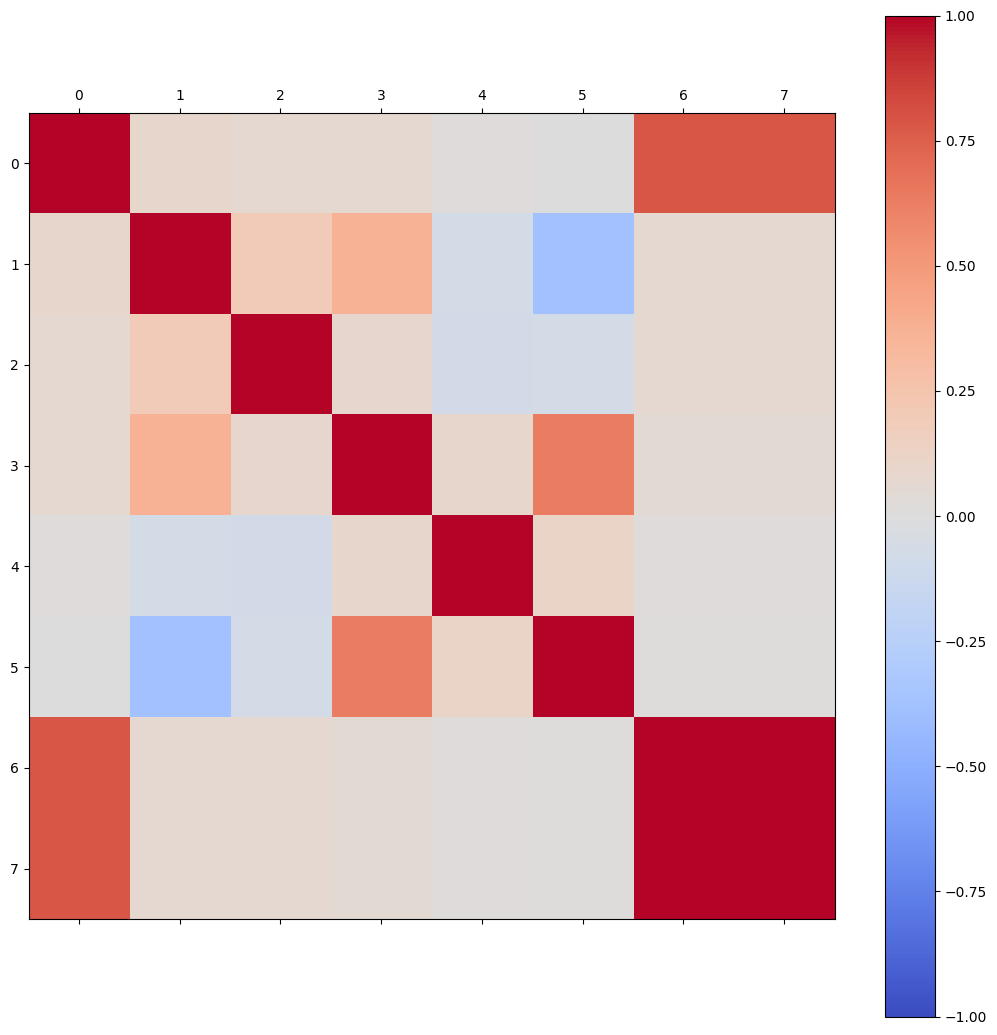

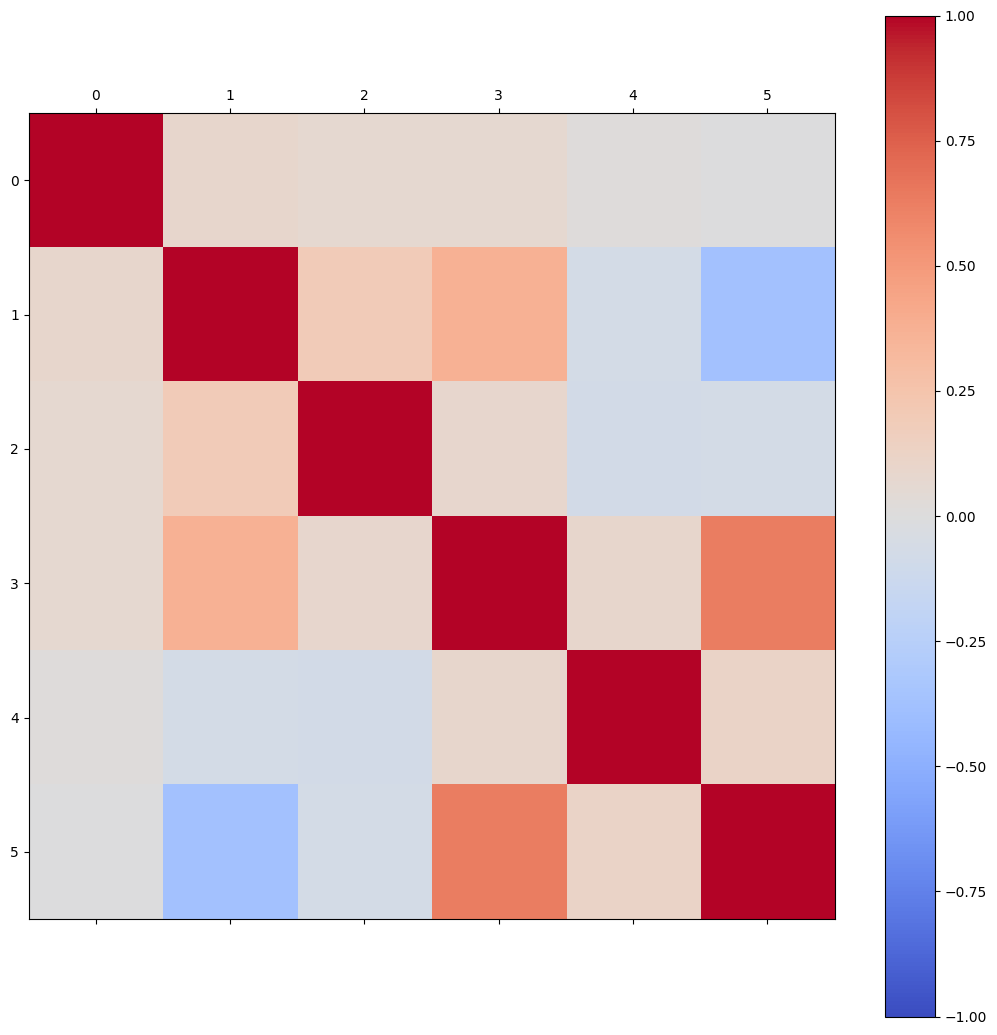

In [140]:
corr_matrix = get_corr_matrix_numerical_attributes(credits_risk_train_set, credit_risk_numerical_attributes_list)

plot_heat_map(corr_matrix)
credit_risk_numerical_attributes_elimination = deepcopy(credit_risk_numerical_attributes_list)
credit_risk_numerical_attributes_elimination.remove('credit_history_length_months')
credit_risk_numerical_attributes_elimination.remove('credit_history_length_years')
corr_matrix = get_corr_matrix_numerical_attributes(credits_risk_train_set, credit_risk_numerical_attributes_elimination)
plot_heat_map(corr_matrix)

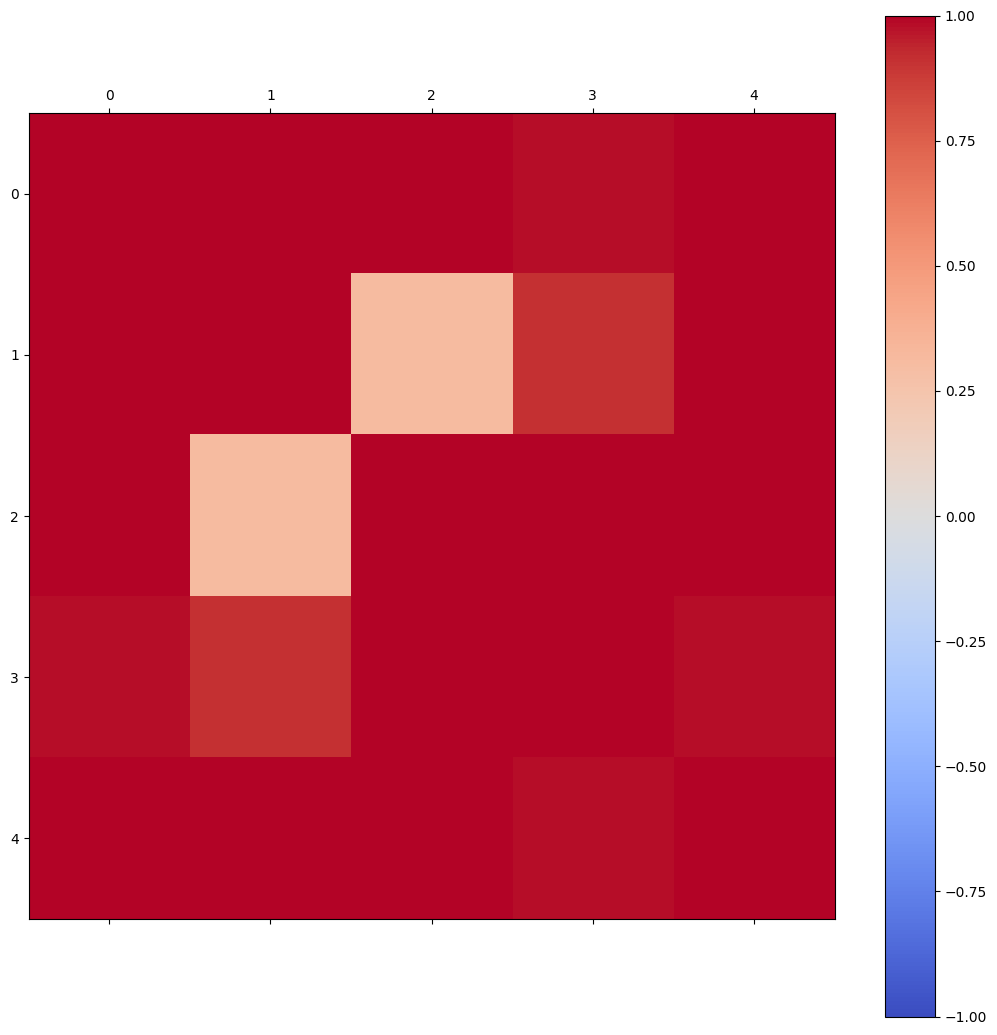

['loan_purpose', 'loan_rating']


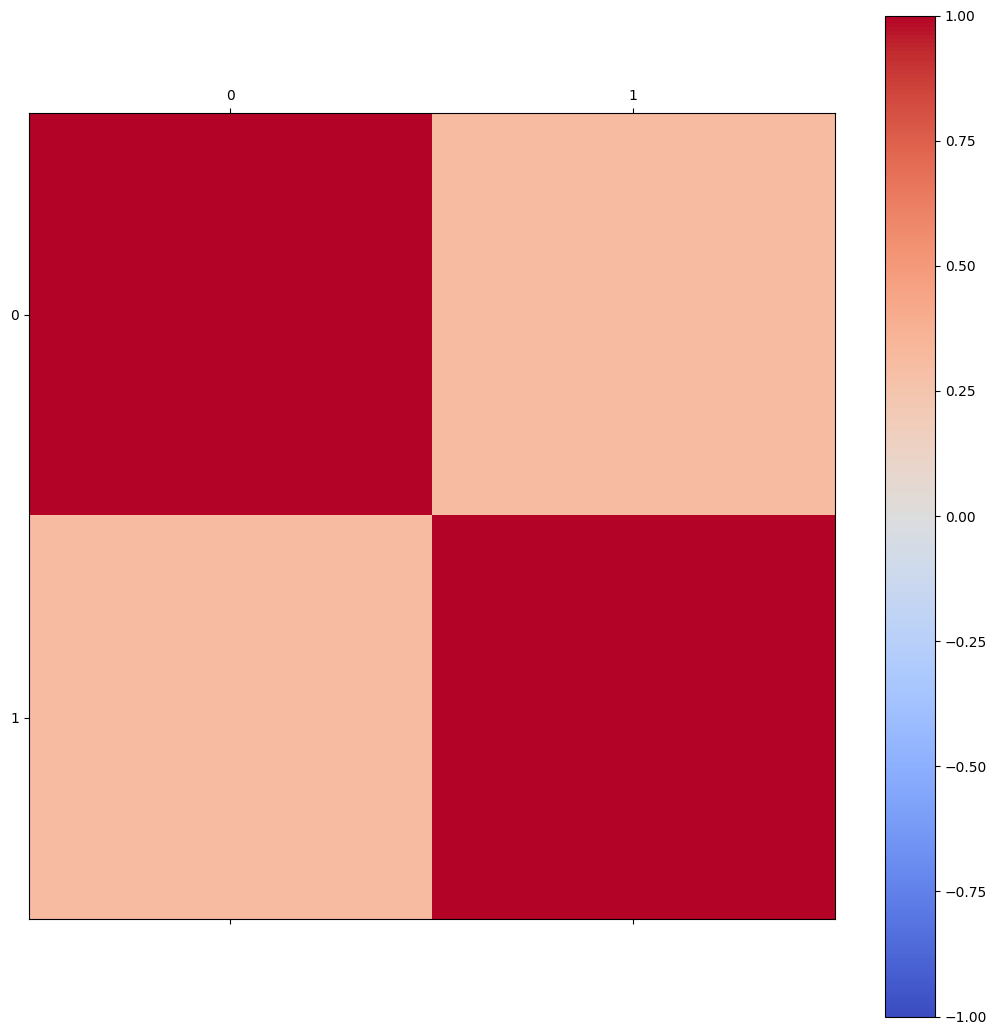

{'loan_purpose': 0.6535387221133129, 'loan_rating': 0.6535387221133129}


In [141]:
corr_matrix = get_corr_matrix_discrete_ordinal_attributes(credits_risk_train_set, credit_risk_ordinal_attributes_list)
plot_heat_map(corr_matrix)

credit_risk_ordinal_elimination = deepcopy(credit_risk_ordinal_attributes_list)
credit_risk_ordinal_elimination.remove('residential_status')
credit_risk_ordinal_elimination.remove('stability_rating')
credit_risk_ordinal_elimination.remove('credit_history_default_status')

print(credit_risk_ordinal_elimination)

corr_matrix = get_corr_matrix_discrete_ordinal_attributes(credits_risk_train_set, credit_risk_ordinal_elimination)
plot_heat_map(corr_matrix)

means = {}
for attribute in credit_risk_ordinal_elimination:
    means[attribute] = corr_matrix[attribute].mean()
print(means)

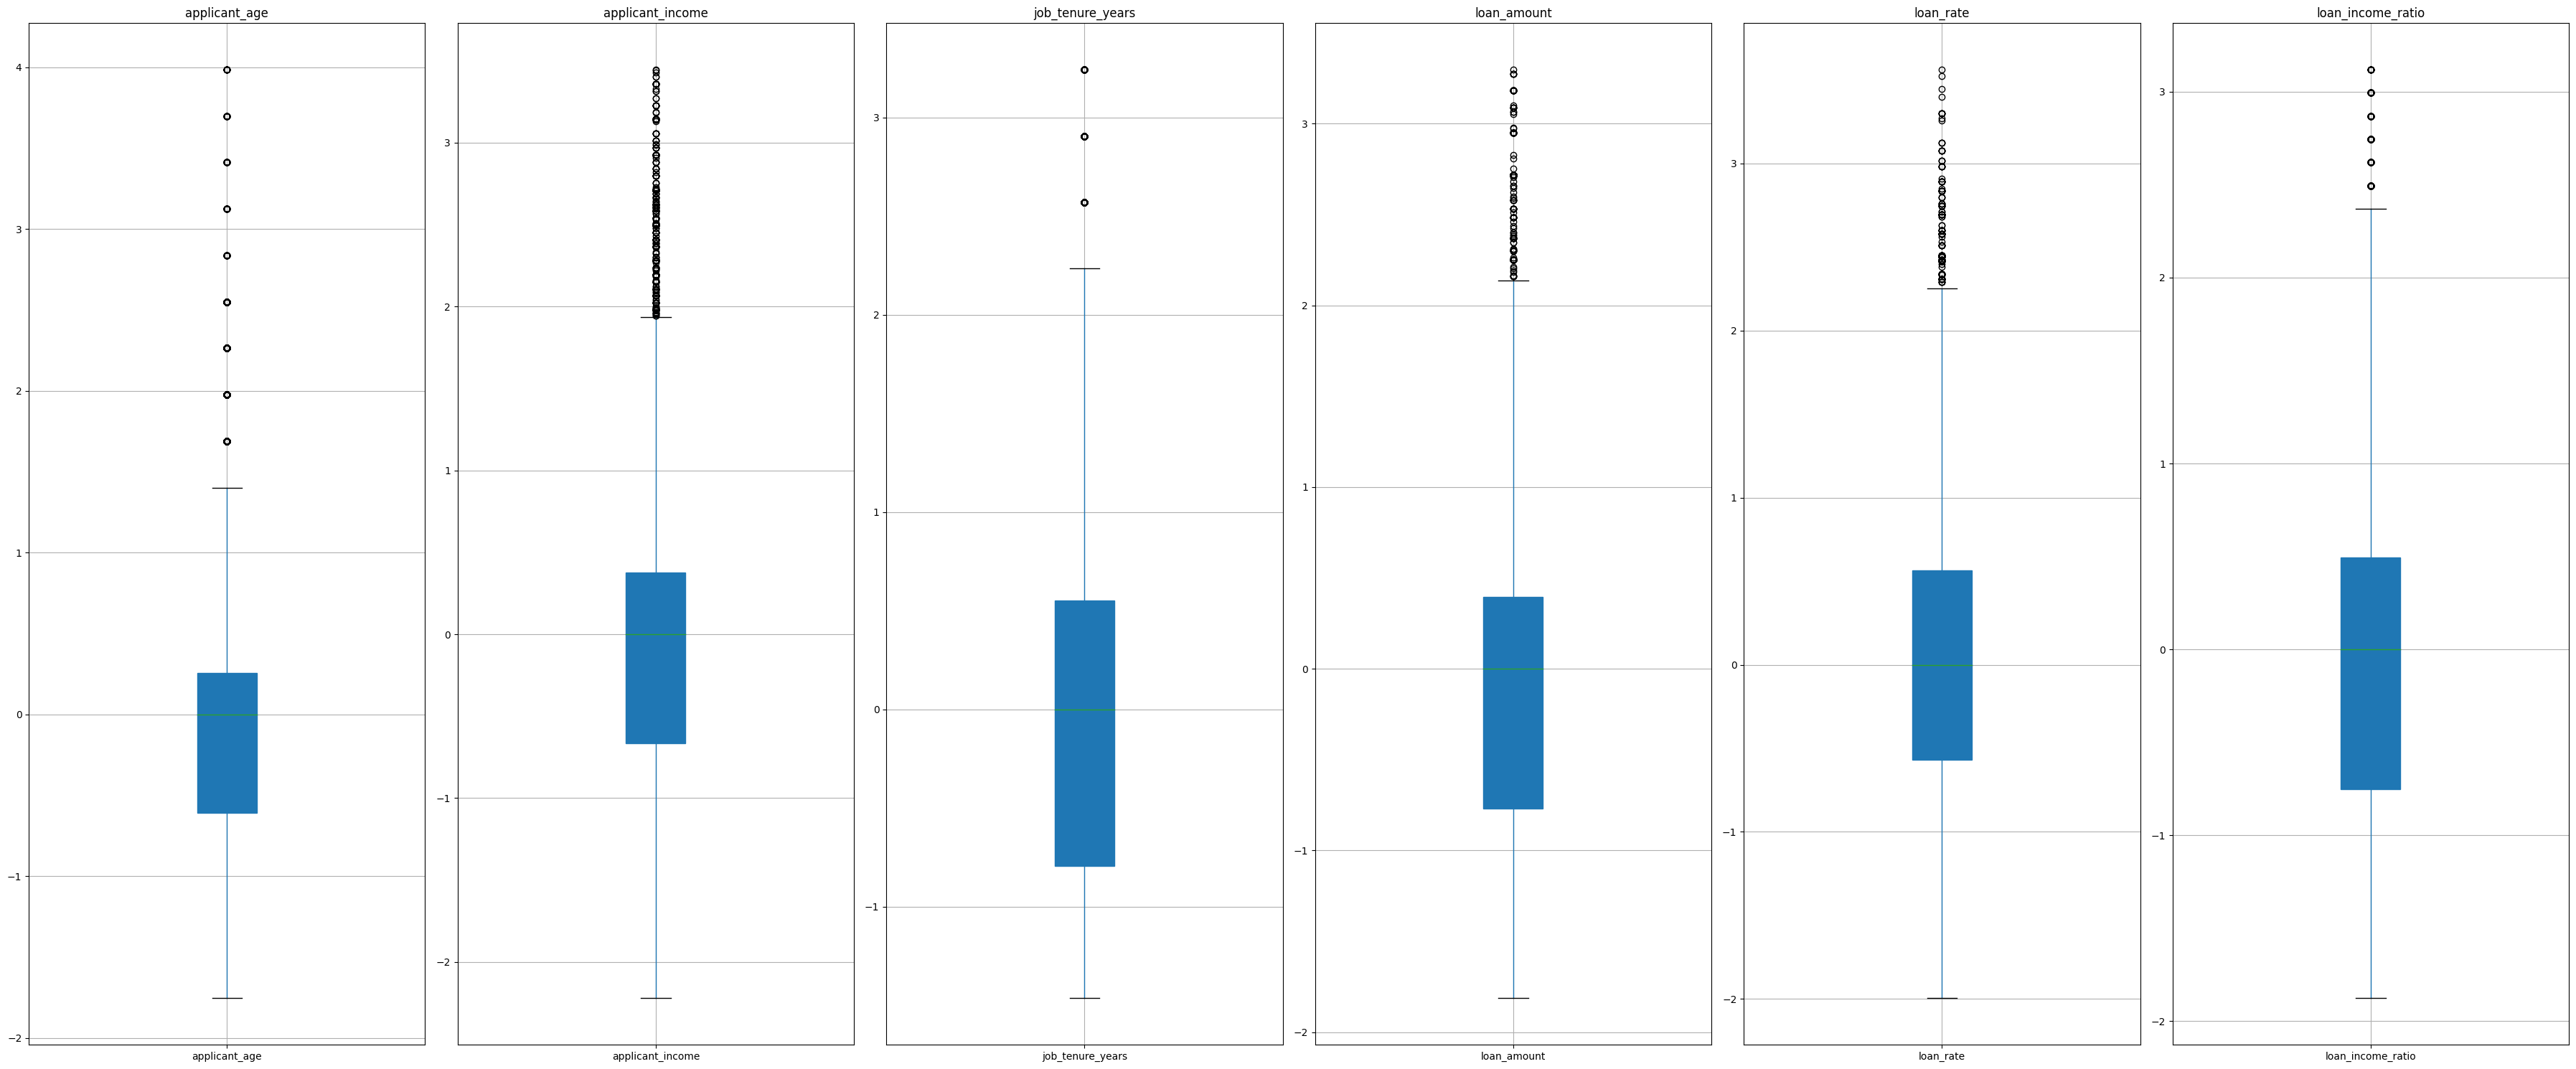

In [142]:
credit_risk_full_set[credit_risk_numerical_attributes_elimination] = normalize_numerical_attributes(credit_risk_full_set, credit_risk_numerical_attributes_elimination)
plot_numerical_attributes(credit_risk_full_set, credit_risk_numerical_attributes_elimination)

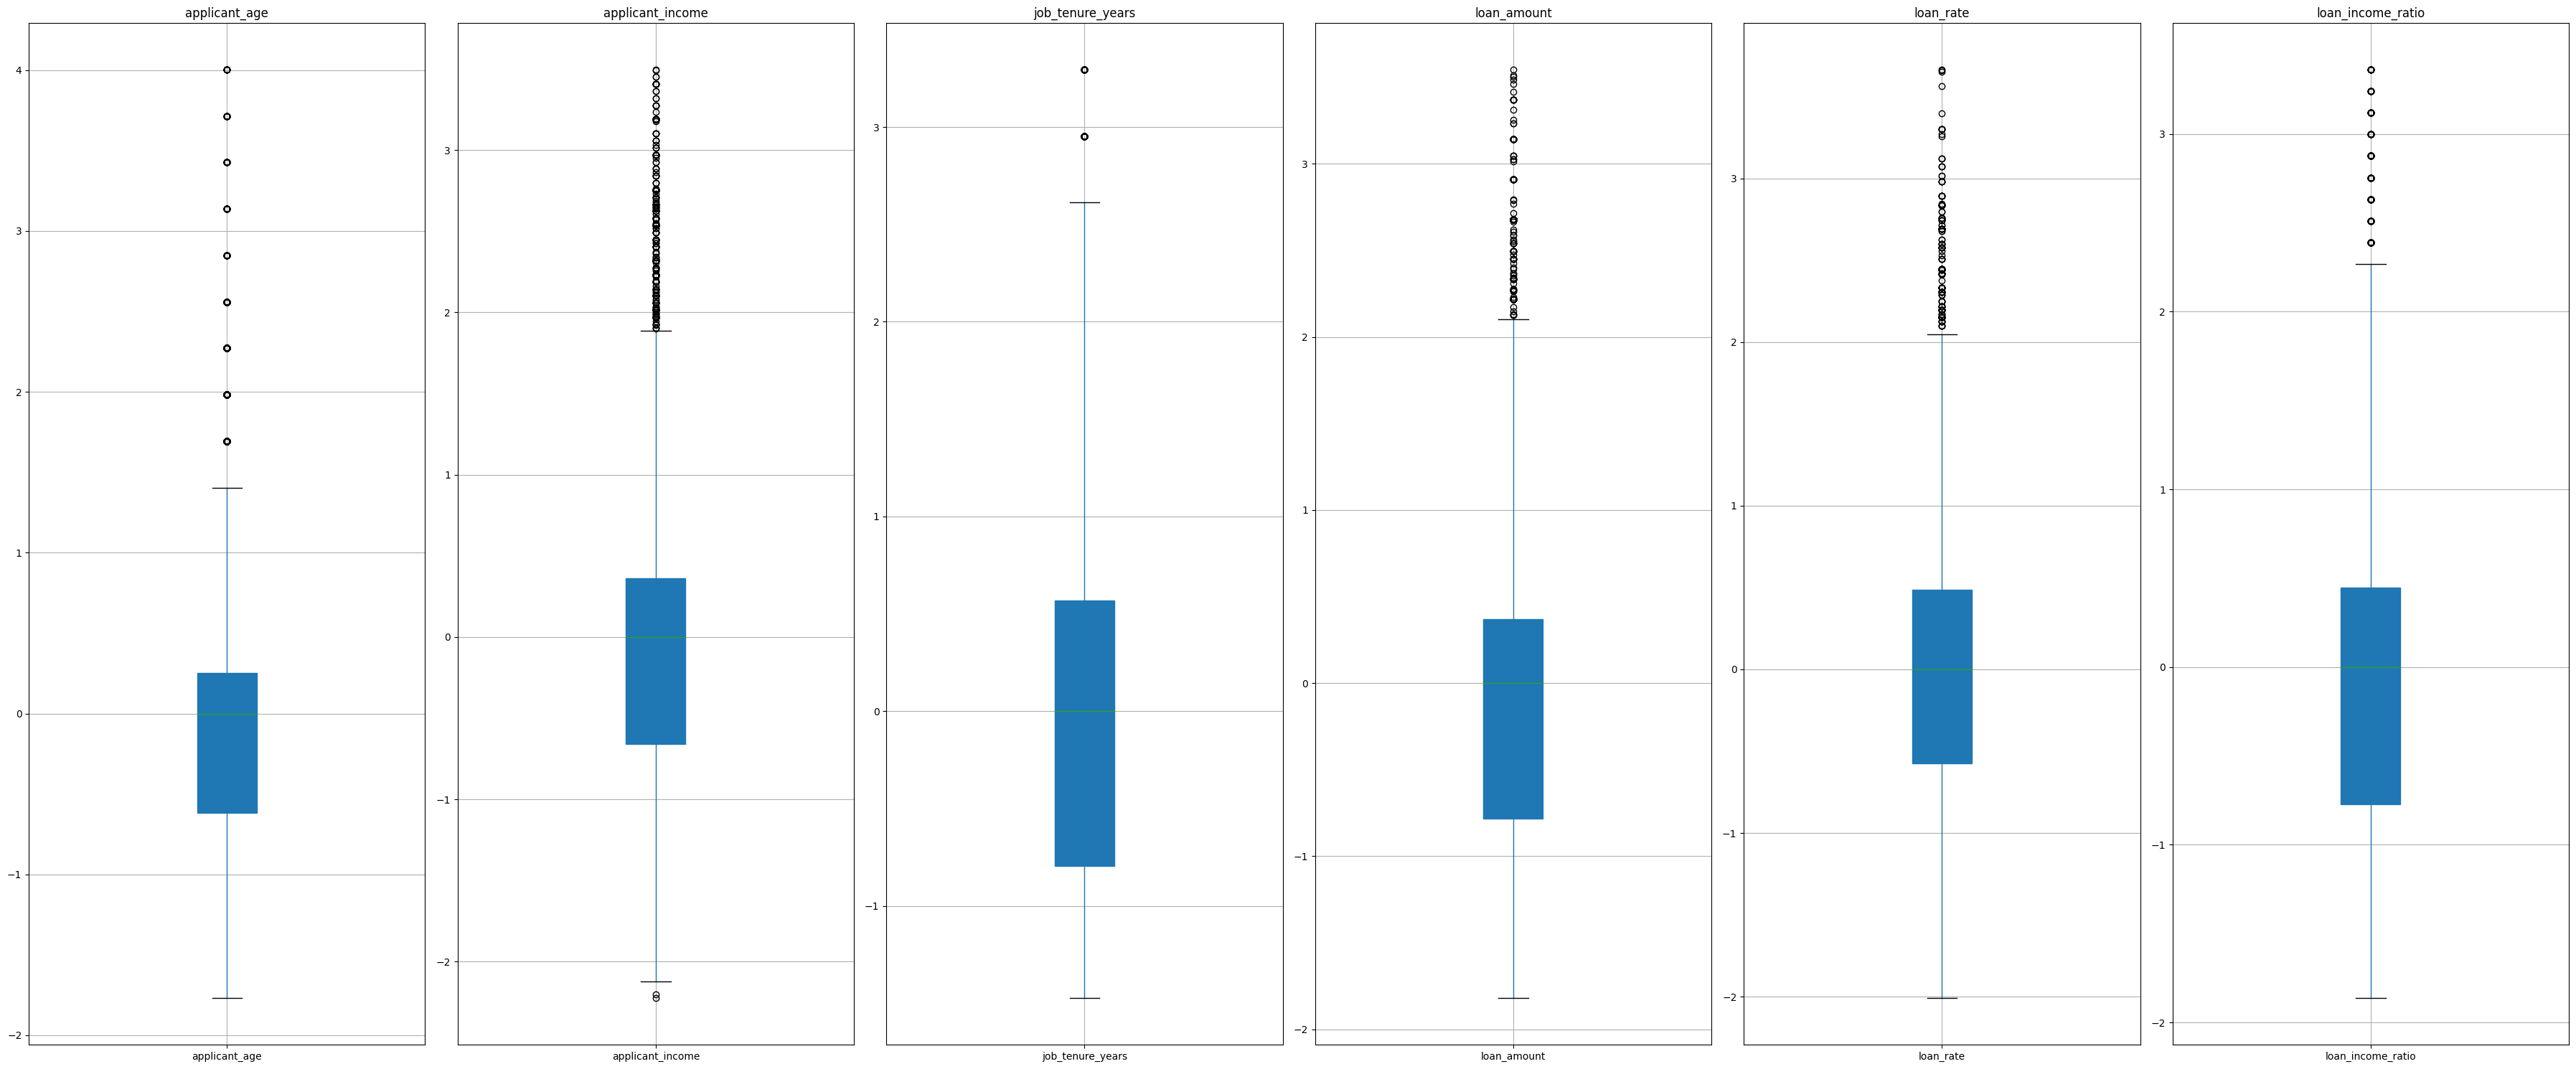

In [143]:
credits_risk_train_set[credit_risk_numerical_attributes_elimination] = normalize_numerical_attributes(credits_risk_train_set, credit_risk_numerical_attributes_elimination)
plot_numerical_attributes(credits_risk_train_set, credit_risk_numerical_attributes_elimination)

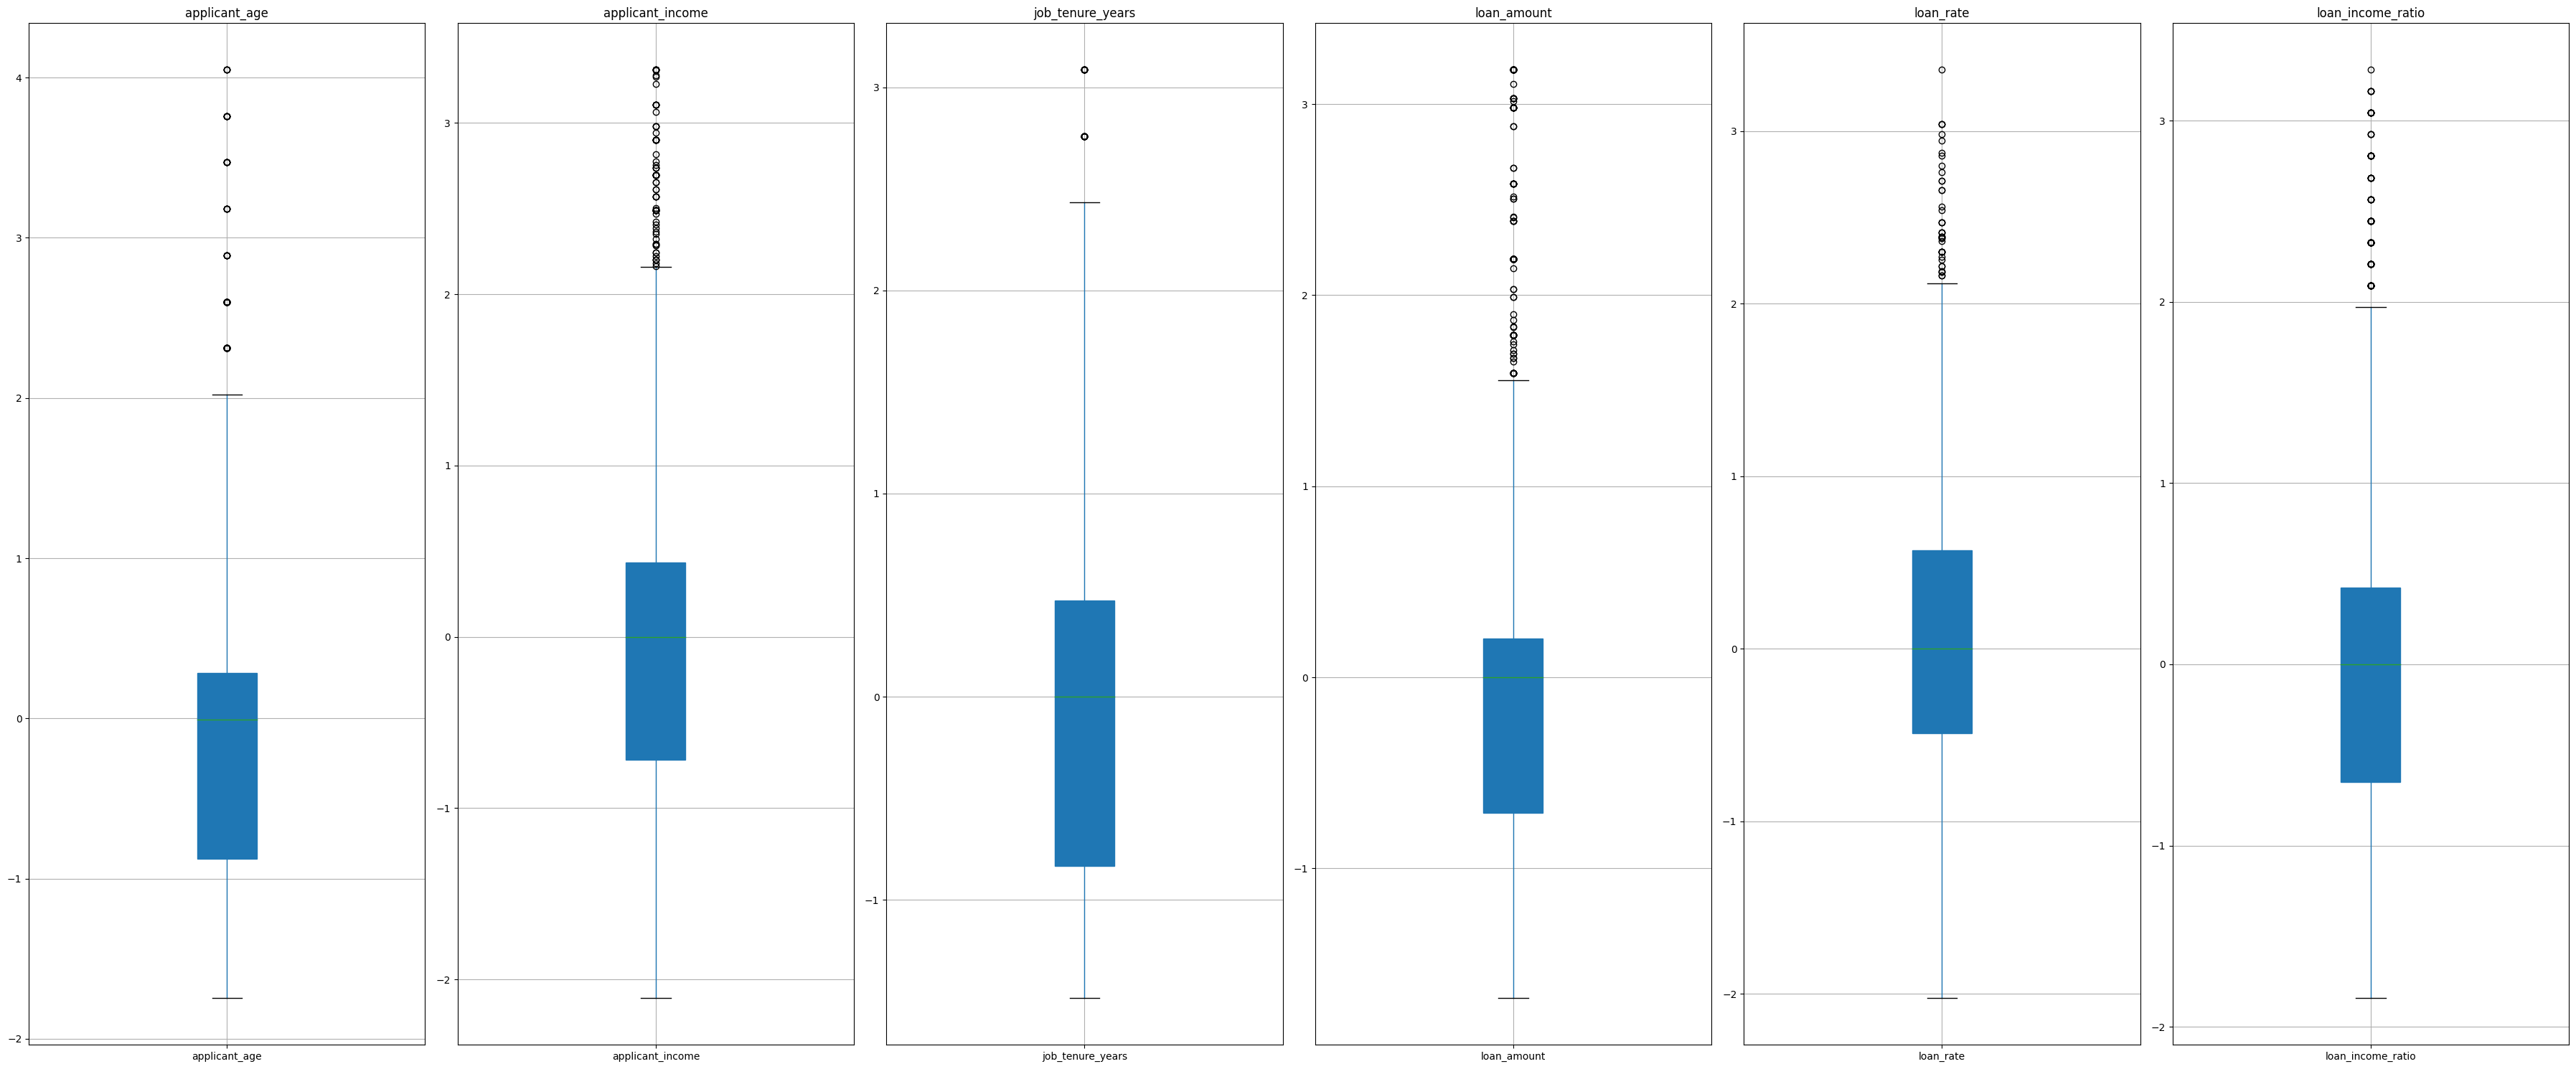

In [144]:
credits_risk_test_set[credit_risk_numerical_attributes_elimination] = normalize_numerical_attributes(credits_risk_test_set, credit_risk_numerical_attributes_elimination)
plot_numerical_attributes(credits_risk_test_set, credit_risk_numerical_attributes_elimination)

# Algorithms

# Random Forrest

Random Forrest Classifier

In [145]:
credit_risk_full_set[credit_risk_ordinal_elimination] = encode_data(credit_risk_full_set, credit_risk_ordinal_elimination)
credits_risk_train_set[credit_risk_ordinal_elimination] = encode_data(credits_risk_train_set, credit_risk_ordinal_elimination)
credits_risk_test_set[credit_risk_ordinal_elimination] = encode_data(credits_risk_test_set, credit_risk_ordinal_elimination)

credit_risk_full_set[credit_risk_ordinal_elimination]

,loan_purpose,loan_rating
0,5,5
1,0,2
2,0,5
3,4,0
4,2,3
...,...,...
9995,0,4
9996,0,5
9997,3,3
9998,4,3


C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


{'n_estimators': 133, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 110, 'class_weight': 'balanced_subsample', 'bootstrap': False}
              precision    recall  f1-score   support

    Approved       0.90      0.90      0.90      1564
    Declined       0.65      0.64      0.65       436

    accuracy                           0.85      2000
   macro avg       0.78      0.77      0.77      2000
weighted avg       0.85      0.85      0.85      2000

F1 score: 0.8460502733449492
Precision score: 0.8456260009881907
Recall score: 0.8465
Accuracy score: 0.8465


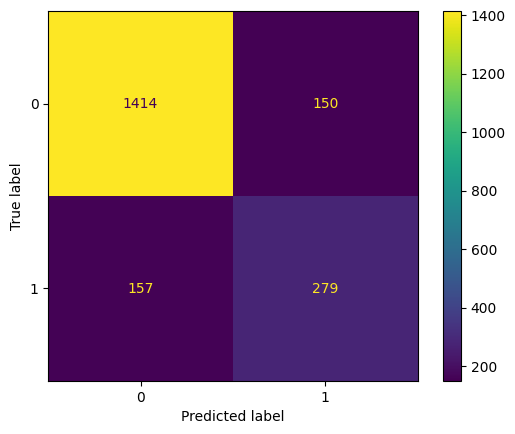

In [146]:
predictions, best_params = find_best_parameters(credits_risk_train_set, credits_risk_test_set, credit_risk_numerical_attributes_elimination + credit_risk_ordinal_elimination, 'loan_approval_status', classifier)

print(best_params)
print(classification_report(credits_risk_test_set['loan_approval_status'], predictions))
print(f"F1 score: {f1_score(credits_risk_test_set['loan_approval_status'], predictions, average='weighted')}")
print(f"Precision score: {precision_score(credits_risk_test_set['loan_approval_status'], predictions, average='weighted')}")
print(f"Recall score: {recall_score(credits_risk_test_set['loan_approval_status'], predictions, average='weighted')}")
print(f"Accuracy score: {accuracy_score(credits_risk_test_set['loan_approval_status'], predictions)}")
ConfusionMatrixDisplay(confusion_matrix(credits_risk_test_set['loan_approval_status'], predictions)).plot()

Random Forrest Implementation

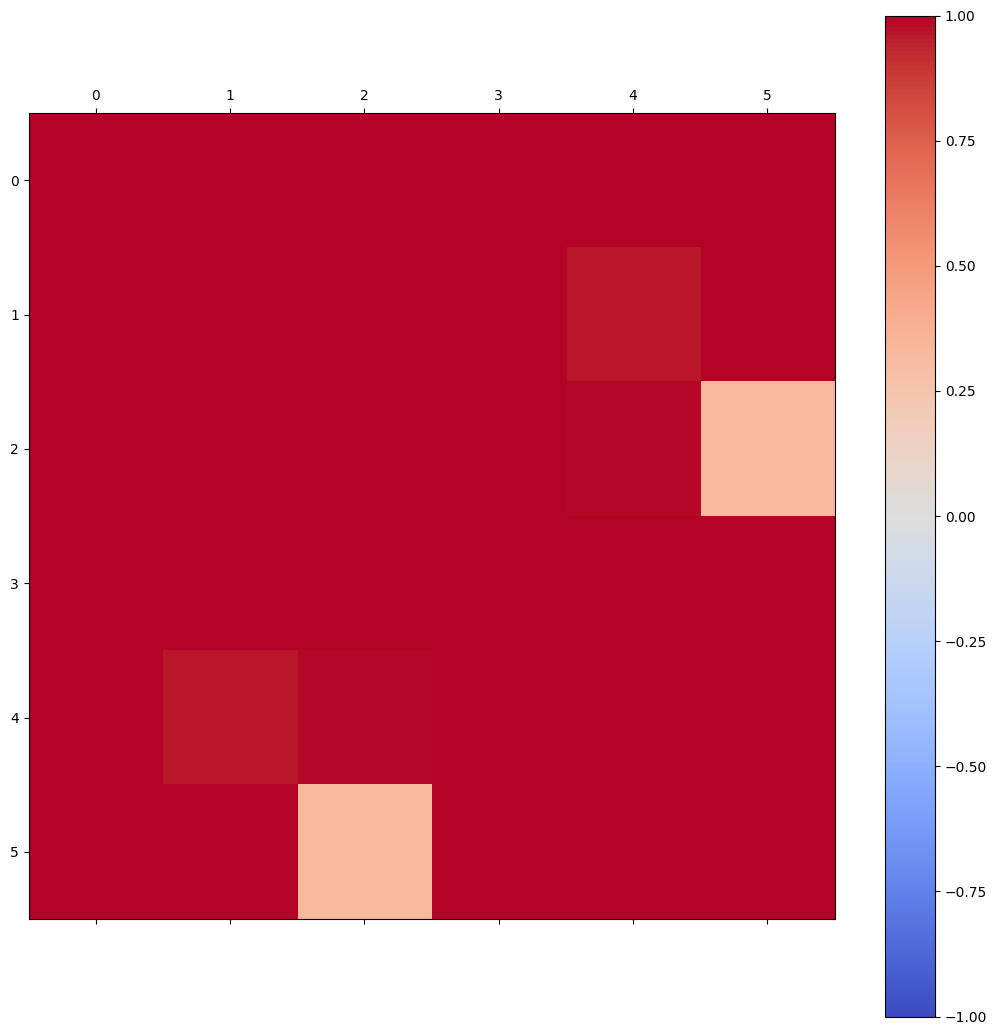

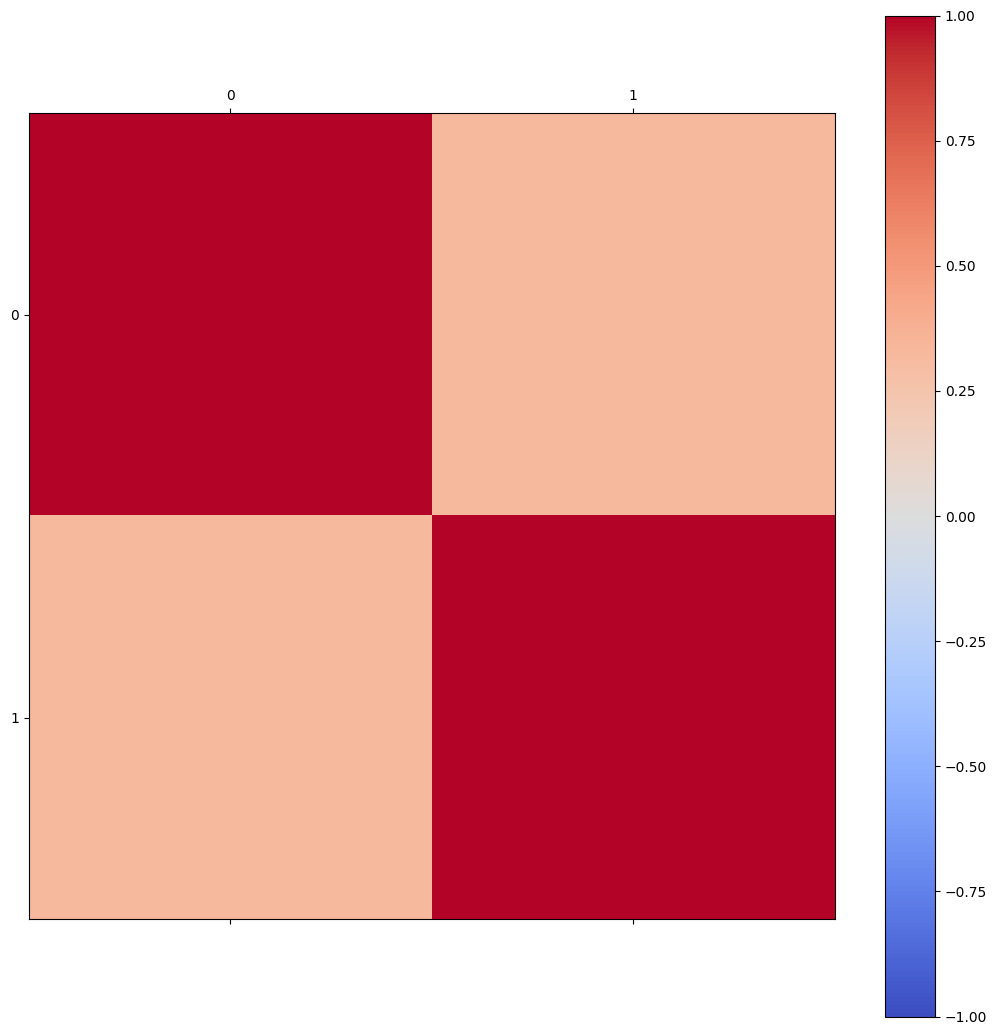

In [147]:
credit_risk_full_set_aux = deepcopy(credit_risk_full_set)
credit_risk_train_set_aux = deepcopy(credits_risk_train_set)
credit_risk_test_set_aux = deepcopy(credits_risk_test_set)

credit_risk_full_set[credit_risk_numerical_attributes_elimination] = categorize_numerical_attributes(credit_risk_full_set, credit_risk_numerical_attributes_elimination, 5)
credits_risk_train_set[credit_risk_numerical_attributes_elimination] = categorize_numerical_attributes(credits_risk_train_set, credit_risk_numerical_attributes_elimination, 2)
credits_risk_test_set[credit_risk_numerical_attributes_elimination] = categorize_numerical_attributes(credits_risk_test_set, credit_risk_numerical_attributes_elimination, 3)

corr_matrix = get_corr_matrix_discrete_ordinal_attributes(credits_risk_train_set, credit_risk_numerical_attributes_elimination)
plot_heat_map(corr_matrix)

credit_risk_numerical_elimination = deepcopy(credit_risk_numerical_attributes_elimination)
credit_risk_numerical_elimination.remove('applicant_income')
credit_risk_numerical_elimination.remove('applicant_age')
credit_risk_numerical_elimination.remove('loan_amount')
credit_risk_numerical_elimination.remove('loan_rate')
corr_matrix = get_corr_matrix_discrete_ordinal_attributes(credits_risk_train_set, credit_risk_numerical_elimination)
plot_heat_map(corr_matrix)

In [148]:
random_forest = RandomForest(n_estimators=250, max_depth=150, min_samples_per_node=2, split_strategy='id3')

random_forest.fit(credits_risk_train_set[credit_risk_ordinal_elimination + credit_risk_numerical_elimination], credits_risk_train_set['loan_approval_status'])
predictions = random_forest.predict(credits_risk_test_set[credit_risk_ordinal_elimination + credit_risk_numerical_elimination])

              precision    recall  f1-score   support

    Approved       0.84      0.98      0.90      1564
    Declined       0.85      0.31      0.46       436

    accuracy                           0.84      2000
   macro avg       0.84      0.65      0.68      2000
weighted avg       0.84      0.84      0.81      2000

F1 score: 0.8070575004534736
Precision score: 0.8398
Recall score: 0.838
Accuracy score: 0.838


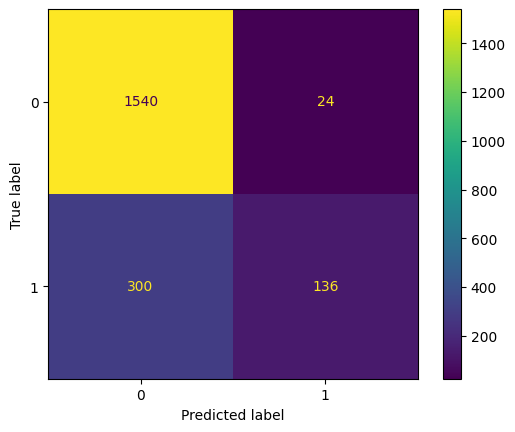

In [149]:
print(classification_report(credits_risk_test_set['loan_approval_status'], predictions))
print(f"F1 score: {f1_score(credits_risk_test_set['loan_approval_status'], predictions, average='weighted')}")
print(f"Precision score: {precision_score(credits_risk_test_set['loan_approval_status'], predictions, average='weighted')}")
print(f"Recall score: {recall_score(credits_risk_test_set['loan_approval_status'], predictions, average='weighted')}")
print(f"Accuracy score: {accuracy_score(credits_risk_test_set['loan_approval_status'], predictions)}")
ConfusionMatrixDisplay(confusion_matrix(credits_risk_test_set['loan_approval_status'], predictions)).plot()

# MLP

MLP Classifier

C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


{'solver': 'adam', 'max_iter': 500, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'alpha': 0.001, 'activation': 'relu'}
              precision    recall  f1-score   support

    Approved       0.86      0.96      0.91      1564
    Declined       0.76      0.44      0.56       436

    accuracy                           0.85      2000
   macro avg       0.81      0.70      0.73      2000
weighted avg       0.84      0.85      0.83      2000

F1 score: 0.8325673501575214
Precision: 0.8395276419655604
Recall: 0.8485
Accuracy: 0.8485


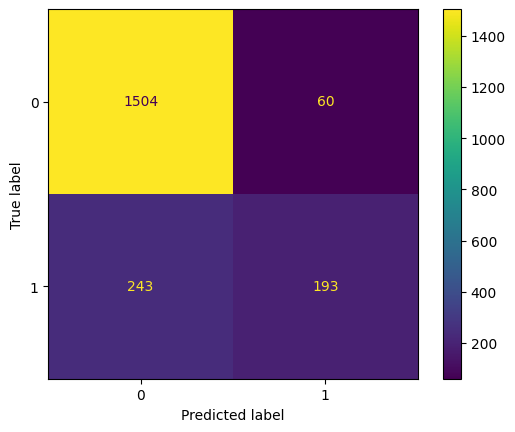

In [150]:
predictions, best_params = find_best_parameters_mlp(credit_risk_train_set_aux, credit_risk_test_set_aux, credit_risk_numerical_attributes_elimination + credit_risk_ordinal_elimination, 'loan_approval_status')

print(best_params)

print(classification_report(credit_risk_test_set_aux['loan_approval_status'], predictions))
print(f"F1 score: {f1_score(credit_risk_test_set_aux['loan_approval_status'], predictions, average='weighted')}")
print(f"Precision: {precision_score(credit_risk_test_set_aux['loan_approval_status'], predictions, average='weighted')}")
print(f"Recall: {recall_score(credit_risk_test_set_aux['loan_approval_status'], predictions, average='weighted')}")
print(f"Accuracy: {accuracy_score(credit_risk_test_set_aux['loan_approval_status'], predictions)}")
ConfusionMatrixDisplay(confusion_matrix(credit_risk_test_set_aux['loan_approval_status'], predictions)).plot()

MLP Implementation

Epoch 01 | Batch 124 | Train NLL:  3.484 | Train Acc:  43.75% | Test NLL:  8.544 | Test Acc: 46.95%
Epoch 02 | Batch 124 | Train NLL:  3.452 | Train Acc:  43.75% | Test NLL:  8.507 | Test Acc: 50.05%
Epoch 03 | Batch 124 | Train NLL:  3.435 | Train Acc:  43.75% | Test NLL:  8.492 | Test Acc: 54.35%
Epoch 04 | Batch 124 | Train NLL:  3.432 | Train Acc:  56.25% | Test NLL:  8.500 | Test Acc: 58.95%
Epoch 05 | Batch 124 | Train NLL:  3.448 | Train Acc:  68.75% | Test NLL:  8.530 | Test Acc: 64.80%
Epoch 06 | Batch 124 | Train NLL:  3.479 | Train Acc:  75.00% | Test NLL:  8.584 | Test Acc: 71.80%
Epoch 07 | Batch 124 | Train NLL:  3.534 | Train Acc:  81.25% | Test NLL:  8.661 | Test Acc: 75.35%
Epoch 08 | Batch 124 | Train NLL:  3.614 | Train Acc:  87.50% | Test NLL:  8.763 | Test Acc: 77.20%
Epoch 09 | Batch 124 | Train NLL:  3.726 | Train Acc:  87.50% | Test NLL:  8.887 | Test Acc: 77.85%
Epoch 10 | Batch 124 | Train NLL:  3.870 | Train Acc:  87.50% | Test NLL:  9.033 | Test Acc: 78.20%


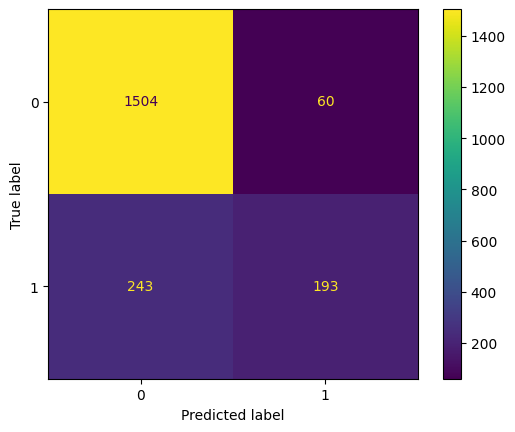

In [151]:
BATCH_SIZE = 16
HIDDEN_UNITS = 128
EPOCHS_NO = 20

credit_risk_test_set_aux['loan_approval_status'] = encode_data(credit_risk_test_set_aux, ['loan_approval_status'])
credit_risk_train_set_aux['loan_approval_status'] = encode_data(credit_risk_train_set_aux, ['loan_approval_status'])

def accuracy(y: np.ndarray, t: np.ndarray) -> float:
      return np.mean(np.argmax(y, axis=1) == t)

optimize_args = {'mode': 'SGD', 'lr': .00001}

net = FeedForwardNetwork([Linear(len(credit_risk_ordinal_elimination + credit_risk_numerical_elimination), HIDDEN_UNITS),
                          ReLU(),
                          Linear(HIDDEN_UNITS, 2)])
cost_function = CrossEntropy()

for epoch in range(EPOCHS_NO):
    for b_no, idx in enumerate(range(0, len(credit_risk_test_set_aux[credit_risk_ordinal_elimination + credit_risk_numerical_elimination]), BATCH_SIZE)):
        x = np.array(credit_risk_train_set_aux[credit_risk_ordinal_elimination + credit_risk_numerical_elimination][idx:idx + BATCH_SIZE])
        t = np.array(credit_risk_train_set_aux['loan_approval_status'][idx:idx + BATCH_SIZE])
        y = net.forward(x)
        loss = cost_function.forward(y, t)
        dy = cost_function.backward(y, t)
        net.backward(dy)

        net.update(**optimize_args)

        print(f'\rEpoch {epoch + 1:02d} '
              f'| Batch {b_no:03d} '
              f'| Train NLL: {loss:6.3f} '
              f'| Train Acc: {accuracy(y, t) * 100:6.2f}% ', end='')

    y = np.array(net.forward(credit_risk_test_set_aux[credit_risk_ordinal_elimination + credit_risk_numerical_elimination], train=False))
    test_nll = cost_function.forward(y, credit_risk_test_set_aux['loan_approval_status'])
    print(f'| Test NLL: {test_nll:6.3f} '
          f'| Test Acc: {accuracy(y, credit_risk_test_set_aux["loan_approval_status"]) * 100:3.2f}%')

print(classification_report(credits_risk_test_set['loan_approval_status'], predictions))
print(f"F1 score: {f1_score(credits_risk_test_set['loan_approval_status'], predictions, average='weighted')}")
print(f"Precision score: {precision_score(credits_risk_test_set['loan_approval_status'], predictions, average='weighted')}")
print(f"Recall score: {recall_score(credits_risk_test_set['loan_approval_status'], predictions, average='weighted')}")
print(f"Accuracy score: {accuracy_score(credits_risk_test_set['loan_approval_status'], predictions)}")
ConfusionMatrixDisplay(confusion_matrix(credits_risk_test_set['loan_approval_status'], predictions)).plot()